#Main

Environment setup

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, hessian
from jax import random
from tqdm import trange

def smooth_piecewise_nu(x, y, base=1.0, jump=10.0, steep=100.0, boundary=0.5):
    """
    Smooth step-like refractive index field nu(x, y).
    nu transitions from base to jump at y=boundary.
    """
    s = 1.0 / (1.0 + jnp.exp(-steep * (y - boundary)))
    return base * (1 - s) + jump * s

def gaussian_kernel(dx, dy, sigma):
    """Isotropic Gaussian kernel."""
    return jnp.exp(-(dx**2 + dy**2) / (2 * sigma**2))

def compute_pheromone_gradient(pher_points, pher_weights, x, y, sigma):
    """
    Compute ∇phi at (x, y) based on past pheromone points and weights.
    """
    def eval_pher(xx, yy):
        dx = xx - pher_points[:, 0]
        dy = yy - pher_points[:, 1]
        vals = vmap(gaussian_kernel, in_axes=(0, 0, None))(dx, dy, sigma)
        return jnp.log(0.01 + jnp.sum(vals * pher_weights))

    gx = grad(lambda xx: eval_pher(xx, y))(x)
    gy = grad(lambda yy: eval_pher(x, yy))(y)
    return jnp.array([gx, gy])

def compute_pheromone_hessian(pher_points, pher_weights, x, y, sigma):
    """
    Compute Hessian ∇²phi at (x, y) based on Gaussian pheromone sources.
    Returns a (2,2) matrix.
    """
    def eval_phi(xy):
        dx = xy[0] - pher_points[:, 0]
        dy = xy[1] - pher_points[:, 1]
        vals = vmap(gaussian_kernel, in_axes=(0, 0, None))(dx, dy, sigma)
        return jnp.log(0.01 + jnp.sum(vals * pher_weights))

    return hessian(eval_phi)(jnp.array([x, y]))

Uncontrolled forward pass

In [ ]:
def compute_weighted_pheromone_gradient(points, weights, x, y, sigma):
    def eval_pher(xx, yy):
        dx = xx - points[:, 0]
        dy = yy - points[:, 1]
        vals = jnp.exp(-(dx**2 + dy**2) / (2 * sigma**2))
        return jnp.log(0.01 + jnp.sum(vals * weights))

    gx = grad(lambda xx: eval_pher(xx, y))(x)
    gy = grad(lambda yy: eval_pher(x, yy))(y)
    return jnp.array([gx, gy])

In [ ]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, lax

def simulate_forward_batch(key, init_states, pher_points, pher_weights, sigma_pher, dt, num_steps, sigma_noise, goal):
    batch_size = init_states.shape[0]

    def step_fn(carry, _):
        key, state = carry  # state: (B, 3)
        key, subkey = random.split(key)
        x, y, theta = state[:, 0], state[:, 1], state[:, 2]

        # Compute speed (1 / nu)
        nu = smooth_piecewise_nu(x, y)
        # speed = 1.0 / nu
        speed = 1.0

        # Pheromone gradient
        grad_pher = vmap(lambda x_, y_: compute_weighted_pheromone_gradient(
            pher_points, pher_weights, x_, y_, sigma_pher))(x, y)
        n_hat = jnp.stack([-jnp.sin(theta), jnp.cos(theta)], axis=1)
        u_pher = jnp.sum(grad_pher * n_hat, axis=1)

        desired_theta_goal = jnp.arctan2(goal[1] - y, goal[0] - x)
        u_goal = jnp.arctan2(jnp.sin(desired_theta_goal - theta), jnp.cos(desired_theta_goal - theta))

        noise = sigma_noise * random.normal(subkey, (batch_size,))
        theta_new = theta + 1.0 * dt * u_pher + 10.0 * dt * u_goal + jnp.sqrt(dt) * noise

        # Position update
        x_new = x + dt * speed * jnp.cos(theta_new)
        y_new = y + dt * speed * jnp.sin(theta_new)
        state_new = jnp.stack([x_new, y_new, theta_new], axis=1)

        return (key, state_new), state_new

    # Run scan over time
    (_, final_state), trajs = lax.scan(step_fn, (key, init_states), None, length=num_steps)
    return trajs  # shape (T, B, 3)

Adjoint integration

In [ ]:
def integrate_costate(trajs, nu_fn, dt):
    num_steps, batch_size, _ = trajs.shape

    # Vectorized over batch
    dnu_dx = jax.vmap(grad(lambda x_, y_: nu_fn(x_, y_)), in_axes=(0, 0))
    dnu_dy = jax.vmap(grad(lambda y_, x_: nu_fn(x_, y_)), in_axes=(0, 0))

    def adjoint_dynamics(lambda_t, state_t):
        x, y, theta = state_t[:, 0], state_t[:, 1], state_t[:, 2]
        grad_nu = jnp.stack([dnu_dx(x, y), dnu_dy(x, y)], axis=1)  # (B, 2)
        fx_theta = jnp.stack([-jnp.sin(theta), jnp.cos(theta)], axis=1)  # (B, 2)
        dH_dtheta = jnp.sum(lambda_t[:, :2] * fx_theta, axis=1)  # (B,)

        lambda_dot = -jnp.stack([grad_nu[:, 0], grad_nu[:, 1], dH_dtheta], axis=1)
        return lambda_t + lambda_dot * dt  # (B, 3)

    def scan_fn(carry, state_t):
        lam = adjoint_dynamics(carry, state_t)
        return lam, lam

    lambda_T = jnp.zeros((batch_size, 3))
    _, lambda_traj = lax.scan(scan_fn, lambda_T, trajs)
    return lambda_traj[::-1]

Controlled Backward Trajectory (Using APIC)

In [ ]:
def simulate_controlled_backward_pass(
    key, final_states, lambda_traj, pher_points, pher_weights,
    sigma_pher, num_steps, dt, sigma_noise, goal
):
    batch_size = final_states.shape[0]

    # Precompute PRNG keys
    keys = random.split(key, num_steps)
    lambda_traj = lambda_traj

    def step_fn(state, inputs):
        lambda_t, key_t = inputs
        x, y, theta = state[:, 0], state[:, 1], state[:, 2]
        nu = smooth_piecewise_nu(x, y)
        # speed = 1.0 / nu
        speed = 1.0

        # Control from adjoint
        l_theta = lambda_t[:, 2]
        u_control = l_theta

        # Pheromone gradient heading term
        grad_pher = vmap(lambda x_, y_: compute_weighted_pheromone_gradient(
            pher_points, pher_weights, x_, y_, sigma_pher))(x, y)
        n_hat = jnp.stack([-jnp.sin(theta), jnp.cos(theta)], axis=1)
        u_pher = jnp.sum(grad_pher * n_hat, axis=1)

        desired_theta_goal = jnp.arctan2(goal[1] - y, goal[0] - x)
        u_goal = jnp.arctan2(jnp.sin(desired_theta_goal - theta), jnp.cos(desired_theta_goal - theta))

        noise = sigma_noise * random.normal(key_t, shape=(batch_size,))
        theta_new = theta + 1.0 * dt * u_pher + 10.0 * dt * u_goal + 1.0 * dt * u_control + jnp.sqrt(dt) * noise
        x_new = x + dt * speed * jnp.cos(theta_new)
        y_new = y + dt * speed * jnp.sin(theta_new)
        new_state = jnp.stack([x_new, y_new, theta_new], axis=1)
        return new_state, new_state

    inputs = (lambda_traj, keys)
    _, trajs = lax.scan(step_fn, final_states, inputs)
    return trajs

Pheromone deposition

In [ ]:
def downsample_recent_weighted_trajectories(
    all_backward_trajectories, num_trajs_to_sample, weight=1.0, key=None, alpha=0.5
):
    """
    Resample trajectories across all cycles, favoring more recent cycles.

    Args:
        all_backward_trajectories: list of (T, B, 3) arrays, one per cycle.
        num_trajs_to_sample: total number of trajectories to sample.
        weight: pheromone weight per point.
        key: PRNGKey
        alpha: controls how strongly to favor recent cycles (higher = more recent)

    Returns:
        pheromone_points: (T * num_trajs_to_sample, 2)
        pheromone_weights: same shape
    """
    if key is None:
        raise ValueError("Must provide PRNG key.")

    T = all_backward_trajectories[0].shape[0]
    B_per_cycle = [traj.shape[1] for traj in all_backward_trajectories]
    B_total = sum(B_per_cycle)

    # Concatenate all trajectories
    trajs_all = jnp.concatenate(all_backward_trajectories, axis=1)  # (T, B_total, 3)

    # Construct sampling probabilities
    num_cycles = len(all_backward_trajectories)
    cycle_ids = jnp.concatenate([
        jnp.full((B,), i) for i, B in enumerate(B_per_cycle)
    ])  # shape (B_total,)

    # More recent = higher i ⇒ higher probability
    probs = (cycle_ids + 1) ** alpha
    probs = probs / probs.sum()

    num_trajs_to_sample = jnp.minimum(num_trajs_to_sample, B_total)

    # Sample trajectory indices
    idx = random.choice(key, B_total, shape=(num_trajs_to_sample,), p=probs, replace=False)

    # Gather corresponding (T, 2) point trajectories
    sampled = trajs_all[:, idx, :2]  # shape (T, N, 2)
    pheromone_points = sampled.reshape(-1, 2)
    pheromone_weights = jnp.full((pheromone_points.shape[0],), weight)

    return pheromone_points, pheromone_weights

Looped Forward-Backward

In [ ]:
from tqdm import trange

def run_apic_loop(num_cycles, key, init_fn, point_a, point_b, pher_sigma, forward_params, backward_params):
    all_pher_points = jnp.empty((0, 2))
    all_pher_weights = jnp.empty((0,))
    all_forward = []
    all_backward = []

    for _ in trange(num_cycles):
        # Split once per iteration to get clean keys for each stage
        key, k_init, k_fwd, k_adj, k_bwd = random.split(key, 5)

        # === Init from Nest ===
        init_states = init_fn(k_init)

        # === Forward Pass ===
        trajs_forward = simulate_forward_batch(
            k_fwd, init_states, all_pher_points, all_pher_weights,
            pher_sigma, forward_params["dt"], forward_params["num_steps"], forward_params["sigma_noise"], point_b
        )

        all_forward.append(trajs_forward)

        # === Adjoint Integration ===
        lambda_traj = integrate_costate(trajs_forward, smooth_piecewise_nu, forward_params["dt"])

        # === Backward Pass with Control ===
        final_states = trajs_forward[-1]
        x, y, theta = final_states[:, 0], final_states[:, 1], final_states[:, 2]
        theta_flipped = theta + jnp.pi
        theta_flipped = jnp.mod(theta_flipped, 2 * jnp.pi)  # keep within [0, 2π)
        final_states_rotated = jnp.stack([x, y, theta_flipped], axis=1)

        trajs_backward = simulate_controlled_backward_pass(
            k_bwd, final_states_rotated, lambda_traj,
            all_pher_points, all_pher_weights, pher_sigma,
            backward_params["num_steps"], backward_params["dt"],
            backward_params["sigma_noise"], point_a
        )

        all_backward.append(trajs_backward)

        key, k_phen = random.split(key)
        all_pher_points, all_pher_weights = downsample_recent_weighted_trajectories(
            all_backward_trajectories=all_backward,
            num_trajs_to_sample=200,  # or however many trajectories you want
            weight=1.0,
            key=k_phen
        )


    return all_forward, all_backward, all_pher_points, all_pher_weights

Plot

In [ ]:
import plotly.graph_objects as go

def plot_all_trajectories_plotly(trajs, point_a, point_b, pheromone_points=None):
    fig = go.Figure()

    # === Pheromone Heatmap ===
    if pheromone_points is not None and len(pheromone_points) > 0:
        fig.add_trace(go.Histogram2d(
            x=pheromone_points[:, 0],
            y=pheromone_points[:, 1],
            colorscale='YlOrRd',
            showscale=True,
            opacity=0.6,
            nbinsx=200,
            nbinsy=200,
            colorbar=dict(
                title="Pheromone Density",
                x=1.05,          # move colorbar to the right
                xanchor='left',
                len=0.7
            ),
            xbins=dict(start=-0.1, end=1.1, size=0.01),
            ybins=dict(start=-0.1, end=1.1, size=0.01)
        ))

    # === Trajectories ===
    for i in range(trajs.shape[1]):
        fig.add_trace(go.Scatter(
            x=trajs[:, i, 0], y=trajs[:, i, 1],
            mode='lines', line=dict(width=1, color='black'),
            opacity=0.8, showlegend=False
        ))

    # === Start and Goal Points ===
    fig.add_trace(go.Scatter(
        x=[point_a[0]], y=[point_a[1]],
        mode='markers+text',
        marker=dict(color='red', size=10),
        text=["Start"], textposition="top right",
        name='Start'
    ))
    fig.add_trace(go.Scatter(
        x=[point_b[0]], y=[point_b[1]],
        mode='markers+text',
        marker=dict(color='blue', size=10, symbol='x'),
        text=["Goal"], textposition="bottom right",
        name='Goal'
    ))

    # === Refractive Boundary ===
    fig.add_trace(go.Scatter(
        x=[-0.1, 1.1], y=[0.5, 0.5],
        mode='lines', line=dict(dash='dash', color='gray'),
        name='Refractive Boundary'
    ))

    # === Layout ===
    fig.update_layout(
        title="Controlled Agent Trajectories with Pheromone Heatmap",
        xaxis_title="X", yaxis_title="Y",
        xaxis=dict(showgrid=False, zeroline=False, range=[-0.1, 1.1]),
        yaxis=dict(showgrid=False, zeroline=False, range=[-0.1, 1.1]),
        plot_bgcolor='white',
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.5)'),
        margin=dict(l=50, r=100, t=50, b=50),  # extra space on right for colorbar
        width=800, height=800
    )

    return fig

Main

In [ ]:
def make_init_fn(point_a, point_b, batch_size, init_noise=0.001):
    def init_fn(key):
        keys = random.split(key, batch_size)
        def single_agent(k):
            dxdy = random.normal(k, (2,)) * init_noise
            x0 = point_a[0] + dxdy[0]
            y0 = point_a[1] + dxdy[1]
            theta0 = jnp.arctan2(point_b[1] - y0, point_b[0] - x0)
            return jnp.array([x0, y0, theta0])
        return jax.vmap(single_agent)(keys)
    return init_fn

In [ ]:
# === MAIN SIMULATION DRIVER ===
import jax.numpy as jnp
from jax import random

# === Simulation Parameters ===
key = random.PRNGKey(42)
num_cycles = 5
batch_size = 32
num_steps = 1520
dt = 0.001
sigma_noise = 1.0
beta = 1.0
pher_sigma = 0.1

point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([1.0, 1.0])

init_fn = make_init_fn(point_a, point_b, batch_size)

# === Param Dictionaries ===
forward_params = {
    "num_steps": num_steps,
    "dt": dt,
    "beta": beta,
    "sigma_noise": sigma_noise
}

backward_params = {
    "num_steps": num_steps,
    "dt": dt,
    "sigma_noise": sigma_noise
}

# === Run the Full Loop ===
all_forward, all_backward, pher_pts, pher_wts = run_apic_loop(
    num_cycles=num_cycles,
    key=random.PRNGKey(0),
    init_fn=init_fn,
    point_a=point_a,
    point_b=point_b,
    pher_sigma=0.05,
    forward_params={"dt": dt, "num_steps": num_steps, "sigma_noise": sigma_noise},
    backward_params=backward_params
)

100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


In [ ]:
fig = plot_all_trajectories_plotly(all_forward[-1], point_a, point_b, pheromone_points=pher_pts)
fig.show()

In [ ]:
import jax.numpy as jnp

def arc_length(x, y):
    dx = jnp.diff(x)
    dy = jnp.diff(y)
    return jnp.sum(jnp.sqrt(dx**2 + dy**2))

def compute_sin_ratio(trajs):
    """
    trajs: (T, B, 3) array of trajectories
    Returns: (B,) array of sin(incident)/sin(refracted) ratios
    """
    T, B, _ = trajs.shape
    ratios = []

    for i in range(B):
        traj = trajs[:, i]
        x = traj[:, 0]
        y = traj[:, 1]

        # Find first crossing of y = 0.5
        crossing_idx = jnp.argmax(y > 0.5)
        if y[crossing_idx] <= 0.5 or crossing_idx == 0 or crossing_idx == T-1:
            ratios.append(jnp.nan)
            continue

        # Incident and refracted segments
        y1 = y[:crossing_idx+1]
        x1 = x[:crossing_idx+1]
        len1 = arc_length(x1, y1)
        dy1 = y1[-1] - y1[0]
        cos1 = dy1 / len1
        sin1 = jnp.sqrt(1.0 - cos1**2)

        y2 = y[crossing_idx:]
        x2 = x[crossing_idx:]
        len2 = arc_length(x2, y2)
        dy2 = y2[-1] - y2[0]
        cos2 = dy2 / len2
        sin2 = jnp.sqrt(1.0 - cos2**2)

        ratio = sin1 / sin2
        ratios.append(ratio)

    return jnp.array(ratios)

In [ ]:
results = compute_sin_ratio(all_forward[-1])
print(f"Mean Snell ratio: {results.mean():.5f}")
print(f"Refractive index ratio: {smooth_piecewise_nu(0,0)/smooth_piecewise_nu(1,1):.5f}")

Mean Snell ratio: 1.67778
Refractive index ratio: 0.10000


#Main 2

Environment setup

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, hessian
from jax import random
from tqdm import trange

def smooth_piecewise_nu(x, y, base=1.0, jump=10.0, steep=10.0, boundary=0.5):
    """
    Smooth step-like refractive index field nu(x, y).
    nu transitions from base to jump at y=boundary.
    """
    s = 1.0 / (1.0 + jnp.exp(-steep * (y - boundary)))
    return base * (1 - s) + jump * s

def gaussian_kernel(dx, dy, sigma):
    """Isotropic Gaussian kernel."""
    return jnp.exp(-(dx**2 + dy**2) / (2 * sigma**2))

def compute_pheromone_gradient(pher_points, pher_weights, x, y, sigma):
    """
    Compute ∇phi at (x, y) based on past pheromone points and weights.
    """
    def eval_pher(xx, yy):
        dx = xx - pher_points[:, 0]
        dy = yy - pher_points[:, 1]
        vals = vmap(gaussian_kernel, in_axes=(0, 0, None))(dx, dy, sigma)
        return jnp.log(0.01 + jnp.sum(vals * pher_weights))

    gx = grad(lambda xx: eval_pher(xx, y))(x)
    gy = grad(lambda yy: eval_pher(x, yy))(y)
    return jnp.array([gx, gy])

def compute_pheromone_hessian(pher_points, pher_weights, x, y, sigma):
    """
    Compute Hessian ∇²phi at (x, y) based on Gaussian pheromone sources.
    Returns a (2,2) matrix.
    """
    def eval_phi(xy):
        dx = xy[0] - pher_points[:, 0]
        dy = xy[1] - pher_points[:, 1]
        vals = vmap(gaussian_kernel, in_axes=(0, 0, None))(dx, dy, sigma)
        return jnp.log(0.01 + jnp.sum(vals * pher_weights))

    return hessian(eval_phi)(jnp.array([x, y]))

Uncontrolled forward pass

In [ ]:
def compute_weighted_pheromone_gradient(points, weights, x, y, sigma):
    def eval_pher(xx, yy):
        dx = xx - points[:, 0]
        dy = yy - points[:, 1]
        vals = jnp.exp(-(dx**2 + dy**2) / (2 * sigma**2))
        return jnp.log(0.01 + jnp.sum(vals * weights))

    gx = grad(lambda xx: eval_pher(xx, y))(x)
    gy = grad(lambda yy: eval_pher(x, yy))(y)
    return jnp.array([gx, gy])

In [ ]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, lax

def simulate_forward_batch(key, init_states, pher_points, pher_weights, sigma_pher, dt, num_steps, sigma_noise, goal):
    batch_size = init_states.shape[0]

    def step_fn(carry, _):
        key, state = carry  # state: (B, 3)
        key, subkey = random.split(key)
        x, y, theta = state[:, 0], state[:, 1], state[:, 2]

        # Compute speed (1 / nu)
        nu = smooth_piecewise_nu(x, y)
        # speed = 1.0 / nu
        speed = 1.0

        # Pheromone gradient
        grad_pher = vmap(lambda x_, y_: compute_weighted_pheromone_gradient(
            pher_points, pher_weights, x_, y_, sigma_pher))(x, y)
        n_hat = jnp.stack([-jnp.sin(theta), jnp.cos(theta)], axis=1)
        u_pher = jnp.sum(grad_pher * n_hat, axis=1)

        desired_theta_goal = jnp.arctan2(goal[1] - y, goal[0] - x)
        u_goal = jnp.arctan2(jnp.sin(desired_theta_goal - theta), jnp.cos(desired_theta_goal - theta))

        noise = sigma_noise * random.normal(subkey, (batch_size,))
        theta_new = theta + 1.0 * dt * u_pher + 10.0 * dt * u_goal + jnp.sqrt(dt) * noise

        # Position update
        x_new = x + dt * speed * jnp.cos(theta_new)
        y_new = y + dt * speed * jnp.sin(theta_new)
        state_new = jnp.stack([x_new, y_new, theta_new], axis=1)

        return (key, state_new), state_new

    # Run scan over time
    (_, final_state), trajs = lax.scan(step_fn, (key, init_states), None, length=num_steps)
    return trajs  # shape (T, B, 3)

Adjoint integration

In [ ]:
def integrate_costate(trajs, nu_fn, dt):
    num_steps, batch_size, _ = trajs.shape

    # Vectorized over batch
    dnu_dx = jax.vmap(grad(lambda x_, y_: nu_fn(x_, y_)), in_axes=(0, 0))
    dnu_dy = jax.vmap(grad(lambda y_, x_: nu_fn(x_, y_)), in_axes=(0, 0))

    def adjoint_dynamics(lambda_t, state_t):
        x, y, theta = state_t[:, 0], state_t[:, 1], state_t[:, 2]
        grad_nu = jnp.stack([dnu_dx(x, y), dnu_dy(x, y)], axis=1)  # (B, 2)
        fx_theta = jnp.stack([-jnp.sin(theta), jnp.cos(theta)], axis=1)  # (B, 2)
        dH_dtheta = jnp.sum(lambda_t[:, :2] * fx_theta, axis=1)  # (B,)

        lambda_dot = -jnp.stack([grad_nu[:, 0], grad_nu[:, 1], dH_dtheta], axis=1)
        return lambda_t + lambda_dot * dt  # (B, 3)

    def scan_fn(carry, state_t):
        lam = adjoint_dynamics(carry, state_t)
        return lam, lam

    lambda_T = jnp.zeros((batch_size, 3))
    _, lambda_traj = lax.scan(scan_fn, lambda_T, trajs)
    return lambda_traj[::-1]

Controlled Backward Trajectory (Using APIC)

In [ ]:
def simulate_controlled_backward_pass(
    key, final_states, lambda_traj, pher_points, pher_weights,
    sigma_pher, num_steps, dt, sigma_noise, goal
):
    batch_size = final_states.shape[0]

    # Precompute PRNG keys
    keys = random.split(key, num_steps)
    lambda_traj = lambda_traj

    def step_fn(state, inputs):
        lambda_t, key_t = inputs
        x, y, theta = state[:, 0], state[:, 1], state[:, 2]
        nu = smooth_piecewise_nu(x, y)
        # speed = 1.0 / nu
        speed = 1.0

        # Control from adjoint
        l_theta = lambda_t[:, 2]
        u_control = l_theta

        # Pheromone gradient heading term
        grad_pher = vmap(lambda x_, y_: compute_weighted_pheromone_gradient(
            pher_points, pher_weights, x_, y_, sigma_pher))(x, y)
        n_hat = jnp.stack([-jnp.sin(theta), jnp.cos(theta)], axis=1)
        u_pher = jnp.sum(grad_pher * n_hat, axis=1)

        desired_theta_goal = jnp.arctan2(goal[1] - y, goal[0] - x)
        u_goal = jnp.arctan2(jnp.sin(desired_theta_goal - theta), jnp.cos(desired_theta_goal - theta))

        noise = sigma_noise * random.normal(key_t, shape=(batch_size,))
        theta_new = theta + 1.0 * dt * u_pher + 10.0 * dt * u_goal + 1.0 * dt * u_control + jnp.sqrt(dt) * noise
        x_new = x + dt * speed * jnp.cos(theta_new)
        y_new = y + dt * speed * jnp.sin(theta_new)
        new_state = jnp.stack([x_new, y_new, theta_new], axis=1)
        return new_state, new_state

    inputs = (lambda_traj, keys)
    _, trajs = lax.scan(step_fn, final_states, inputs)
    return trajs

Pheromone deposition

In [ ]:
def downsample_recent_weighted_trajectories(
    all_backward_trajectories, num_trajs_to_sample, weight=1.0, key=None, alpha=0.5
):
    """
    Resample trajectories across all cycles, favoring more recent cycles.

    Args:
        all_backward_trajectories: list of (T, B, 3) arrays, one per cycle.
        num_trajs_to_sample: total number of trajectories to sample.
        weight: pheromone weight per point.
        key: PRNGKey
        alpha: controls how strongly to favor recent cycles (higher = more recent)

    Returns:
        pheromone_points: (T * num_trajs_to_sample, 2)
        pheromone_weights: same shape
    """
    if key is None:
        raise ValueError("Must provide PRNG key.")

    T = all_backward_trajectories[0].shape[0]
    B_per_cycle = [traj.shape[1] for traj in all_backward_trajectories]
    B_total = sum(B_per_cycle)

    # Concatenate all trajectories
    trajs_all = jnp.concatenate(all_backward_trajectories, axis=1)  # (T, B_total, 3)

    # Construct sampling probabilities
    num_cycles = len(all_backward_trajectories)
    cycle_ids = jnp.concatenate([
        jnp.full((B,), i) for i, B in enumerate(B_per_cycle)
    ])  # shape (B_total,)

    # More recent = higher i ⇒ higher probability
    probs = (cycle_ids + 1) ** alpha
    probs = probs / probs.sum()

    num_trajs_to_sample = jnp.minimum(num_trajs_to_sample, B_total)

    # Sample trajectory indices
    idx = random.choice(key, B_total, shape=(num_trajs_to_sample,), p=probs, replace=False)

    # Gather corresponding (T, 2) point trajectories
    sampled = trajs_all[:, idx, :2]  # shape (T, N, 2)
    pheromone_points = sampled.reshape(-1, 2)
    pheromone_weights = jnp.full((pheromone_points.shape[0],), weight)

    return pheromone_points, pheromone_weights

Looped Forward-Backward

In [ ]:
from tqdm import trange

def run_apic_loop(num_cycles, key, init_fn, point_a, point_b, pher_sigma, forward_params, backward_params):
    all_pher_points = jnp.empty((0, 2))
    all_pher_weights = jnp.empty((0,))
    all_forward = []
    all_backward = []

    # NEW: Keep track of pheromone points and weights per cycle
    pheromone_history = [(all_pher_points, all_pher_weights)]  # cycle 0 = no pheromone

    for _ in trange(num_cycles):
        # Split once per iteration to get clean keys for each stage
        key, k_init, k_fwd, k_adj, k_bwd = random.split(key, 5)

        # === Init from Nest ===
        init_states = init_fn(k_init)

        # === Forward Pass ===
        trajs_forward = simulate_forward_batch(
            k_fwd, init_states, all_pher_points, all_pher_weights,
            pher_sigma, forward_params["dt"], forward_params["num_steps"], forward_params["sigma_noise"], point_b
        )

        all_forward.append(trajs_forward)

        # === Adjoint Integration ===
        lambda_traj = integrate_costate(trajs_forward, smooth_piecewise_nu, forward_params["dt"])

        # === Backward Pass with Control ===
        final_states = trajs_forward[-1]
        x, y, theta = final_states[:, 0], final_states[:, 1], final_states[:, 2]
        theta_flipped = theta + jnp.pi
        theta_flipped = jnp.mod(theta_flipped, 2 * jnp.pi)  # keep within [0, 2π)
        final_states_rotated = jnp.stack([x, y, theta_flipped], axis=1)

        trajs_backward = simulate_controlled_backward_pass(
            k_bwd, final_states_rotated, lambda_traj,
            all_pher_points, all_pher_weights, pher_sigma,
            backward_params["num_steps"], backward_params["dt"],
            backward_params["sigma_noise"], point_a
        )

        all_backward.append(trajs_backward)

        # === Pheromone Deposition ===
        key, k_phen = random.split(key)
        all_pher_points, all_pher_weights = downsample_recent_weighted_trajectories(
            all_backward_trajectories=all_backward,
            num_trajs_to_sample=200,
            weight=1.0,
            key=k_phen
        )

        # NEW: Save current pheromone state
        pheromone_history.append((all_pher_points, all_pher_weights))

    return all_forward, all_backward, pheromone_history

Plot

In [ ]:
import numpy as np

def compute_pheromone_field(pheromone_points, pheromone_weights, X, Y, sigma=0.05):
    """
    Compute pheromone field φ(x, y) as a log-sum of weighted Gaussians.
    Returns a (grid_size, grid_size) array over X, Y.
    """
    if pheromone_points.shape[0] == 0:
        return np.zeros_like(X)

    dx = X[None, :, :] - pheromone_points[:, 0][:, None, None]  # shape (N, H, W)
    dy = Y[None, :, :] - pheromone_points[:, 1][:, None, None]
    weights = pheromone_weights[:, None, None]  # shape (N, 1, 1)

    gaussians = np.exp(-(dx**2 + dy**2) / (2 * sigma**2)) * weights
    field = np.log(0.01 + np.sum(gaussians, axis=0))  # shape (H, W)
    return field

In [ ]:
def view_decayed_pheromone_fixed_extent(
    all_backward,
    all_forward,
    cycle_idx,
    sigma=0.05,
    decay_rate=0.9,
    grid_size=200,
    batch_size=1000,
    point_a=None,
    point_b=None,
    interface_y=0.5,
    ax=None  # new: allow passing in existing subplot
):
    import matplotlib.colors as mcolors
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    import numpy as np
    import matplotlib.pyplot as plt

    # === Grid setup
    xmin, xmax = -0.2, 1.2
    ymin, ymax = -0.2, 1.2
    x_vals = np.linspace(xmin, xmax, grid_size)
    y_vals = np.linspace(ymin, ymax, grid_size)
    X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')

    dx_spacing = (xmax - xmin) / (grid_size - 1)
    dy_spacing = (ymax - ymin) / (grid_size - 1)
    radius_x = int(np.ceil(3 * sigma / dx_spacing))
    radius_y = int(np.ceil(3 * sigma / dy_spacing))

    # === Pheromone accumulation
    pheromone_field = np.zeros((grid_size, grid_size))
    for i in range(cycle_idx):
        decay = decay_rate ** (cycle_idx - 1 - i)
        trajs = all_backward[i]  # (T, B, 2)
        points = np.reshape(np.array(trajs[:, :, :2]), (-1, 2))

        for j in range(0, len(points), batch_size):
            batch = points[j:j + batch_size]
            for px, py in batch:
                ix = np.searchsorted(x_vals, px)
                iy = np.searchsorted(y_vals, py)
                i0 = max(ix - radius_x, 0)
                i1 = min(ix + radius_x + 1, grid_size)
                j0 = max(iy - radius_y, 0)
                j1 = min(iy + radius_y + 1, grid_size)

                local_x = X[i0:i1, j0:j1]
                local_y = Y[i0:i1, j0:j1]
                dx = local_x - px
                dy = local_y - py
                kernel = np.exp(-(dx**2 + dy**2) / (2 * sigma**2))
                pheromone_field[i0:i1, j0:j1] += decay * kernel

    # === Normalize and clip
    field = np.log(0.01 + pheromone_field)
    norm_field = field / np.max(field) if np.max(field) > 0 else field
    threshold = 0.05
    clipped = np.clip(norm_field, threshold, 1.0)
    cmap = mcolors.LinearSegmentedColormap.from_list('white_orange', ['white', 'orange'])

    # === Axis handling
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    im = ax.imshow(
        clipped.T,  # transpose to align with trajectory coordinates
        origin='lower',
        extent=[xmin, xmax, ymin, ymax],
        cmap=cmap,
        norm=mcolors.Normalize(vmin=threshold, vmax=1.0),
        aspect='auto'
    )

    # === Trajectories
    trajs = all_forward[cycle_idx]
    for b in range(trajs.shape[1]):
        x_traj = np.array(trajs[:, b, 0])
        y_traj = np.array(trajs[:, b, 1])
        ax.plot(x_traj, y_traj, color='tab:red', lw=0.8, alpha=0.8)

    # === Source, target, interface
    if point_a is not None:
        ax.scatter(*point_a, color='blue', s=120, zorder=5)
    if point_b is not None:
        ax.scatter(*point_b, color='green', s=120, zorder=5)
    # ax.axhline(interface_y, color='gray', linestyle='--', lw=1.2)

    # === Legend only if standalone
    if ax is None:
        legend_elements = [
            mpatches.Patch(color='orange', label='Pheromone field'),
            mlines.Line2D([], [], color='tab:red', label='Trajectory', linewidth=1.5),
            mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=6, label='Source'),
            mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=6, label='Target'),
            mlines.Line2D([], [], color='gray', linestyle='--', linewidth=1.2, label='Interface')
        ]
        ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False, fontsize=10)

        ax.set_title(f"Forward pass {cycle_idx}", fontsize=12)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.axis("off")

        plt.tight_layout()
        plt.show()

Main

In [ ]:
def make_init_fn(point_a, point_b, batch_size, init_noise=0.001):
    def init_fn(key):
        keys = random.split(key, batch_size)
        def single_agent(k):
            dxdy = random.normal(k, (2,)) * init_noise
            x0 = point_a[0] + dxdy[0]
            y0 = point_a[1] + dxdy[1]
            theta0 = jnp.arctan2(point_b[1] - y0, point_b[0] - x0)
            return jnp.array([x0, y0, theta0])
        return jax.vmap(single_agent)(keys)
    return init_fn

In [ ]:
# === MAIN SIMULATION DRIVER ===
import jax.numpy as jnp
from jax import random

# === Simulation Parameters ===
key = random.PRNGKey(42)
num_cycles = 6
batch_size = 32
num_steps = 1440
dt = 0.001
sigma_noise = 0.5
beta = 5.0
pher_sigma = 0.01

point_a = jnp.array([0.0, 0.0])
point_b = jnp.array([1.0, 1.0])

init_fn = make_init_fn(point_a, point_b, batch_size)

# === Param Dictionaries ===
forward_params = {
    "num_steps": num_steps,
    "dt": dt,
    "beta": beta,
    "sigma_noise": sigma_noise
}

backward_params = {
    "num_steps": num_steps,
    "dt": dt,
    "sigma_noise": sigma_noise
}

# === Run the Full Loop ===
all_forward, all_backward, pheromone_history = run_apic_loop(
    num_cycles=num_cycles,
    key=random.PRNGKey(0),
    init_fn=init_fn,
    point_a=point_a,
    point_b=point_b,
    pher_sigma=pher_sigma,
    forward_params={"dt": dt, "num_steps": num_steps, "sigma_noise": sigma_noise},
    backward_params=backward_params
)

100%|██████████| 6/6 [00:18<00:00,  3.17s/it]


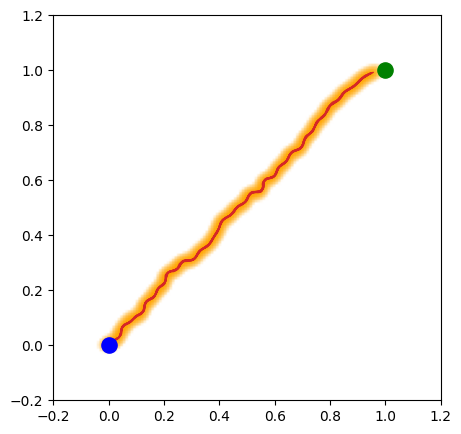

In [ ]:
view_decayed_pheromone_fixed_extent(
    all_backward, all_forward,
    cycle_idx=5,
    sigma=0.01,
    decay_rate=0.1,
    grid_size=150,
    batch_size=1000,
    point_a=point_a,
    point_b=point_b,
    interface_y=0.5
)

In [ ]:
def save_all_cycles_in_row(
    all_backward,
    all_forward,
    sigma=0.05,
    decay_rate=0.9,
    grid_size=200,
    batch_size=1000,
    point_a=None,
    point_b=None,
    interface_y=0.5,
    save_path="pheromone_cycles.pdf"
):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines

    num_cycles = len(all_forward)
    figsize_per_frame = 3.2  # inches per subplot
    fig_height = 4.2         # total figure height

    fig, axes = plt.subplots(
        1, num_cycles,
        figsize=(figsize_per_frame * num_cycles, fig_height),
        constrained_layout=True
    )

    if num_cycles == 1:
        axes = [axes]

    for i in range(num_cycles):
        view_decayed_pheromone_fixed_extent(
            all_backward,
            all_forward,
            cycle_idx=i,
            sigma=sigma,
            decay_rate=decay_rate,
            grid_size=grid_size,
            batch_size=batch_size,
            point_a=point_a,
            point_b=point_b,
            interface_y=interface_y,
            ax=axes[i]
        )
        axes[i].set_title(f"Cycle {i}", fontsize=18)
        axes[i].axis("off")

    # === Shared legend outside plot
    legend_elements = [
        mpatches.Patch(color='orange', label='Pheromone field'),
        mlines.Line2D([], [], color='tab:red', label='Trajectory', linewidth=2),
        mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='Source'),
        mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='Target'),
        mlines.Line2D([], [], color='gray', linestyle='--', linewidth=2, label='Interface'),
    ]
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        ncol=5,
        fontsize=18,
        frameon=False,
        bbox_to_anchor=(0.5, -0.06),
        handlelength=2.5,
        handletextpad=0.8,
        columnspacing=1.5,
        borderaxespad=0.3
    )

    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved to {save_path}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_all_cycles_in_row(
    all_backward=all_backward,
    all_forward=all_forward,
    point_a=point_a,
    point_b=point_b,
    sigma=0.01,
    decay_rate=0.1,
    save_path="pheromone_progression.pdf"
)

Saved to pheromone_progression.pdf


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

def compute_mean_traversal_times(all_forward, dt):
    """
    Mean   Σ ν(x,y)·ds   per cycle.
    dt is the arclength increment.
    """
    nu_vec = jax.vmap(smooth_piecewise_nu, in_axes=(0, 0))  # vectorise over x & y
    mean_times = []

    for trajs in all_forward:
        T, _, _ = trajs.shape                  # read only T
        xy      = np.asarray(trajs)[..., :2]   # keep x-y, drop θ   (T,B,2)
        flat_xy = xy.reshape(-1, 2)            # (T·B, 2)

        x, y    = flat_xy[:, 0], flat_xy[:, 1]
        nu_vals = np.asarray(nu_vec(x, y))     # (T·B,)

        # derive actual B from length
        B_true  = nu_vals.size // T
        nu_vals = nu_vals.reshape(T, B_true)   # (T, B_true)

        traj_times = nu_vals.sum(axis=0) * dt  # integrate along each path
        mean_times.append(traj_times.mean())

    return mean_times

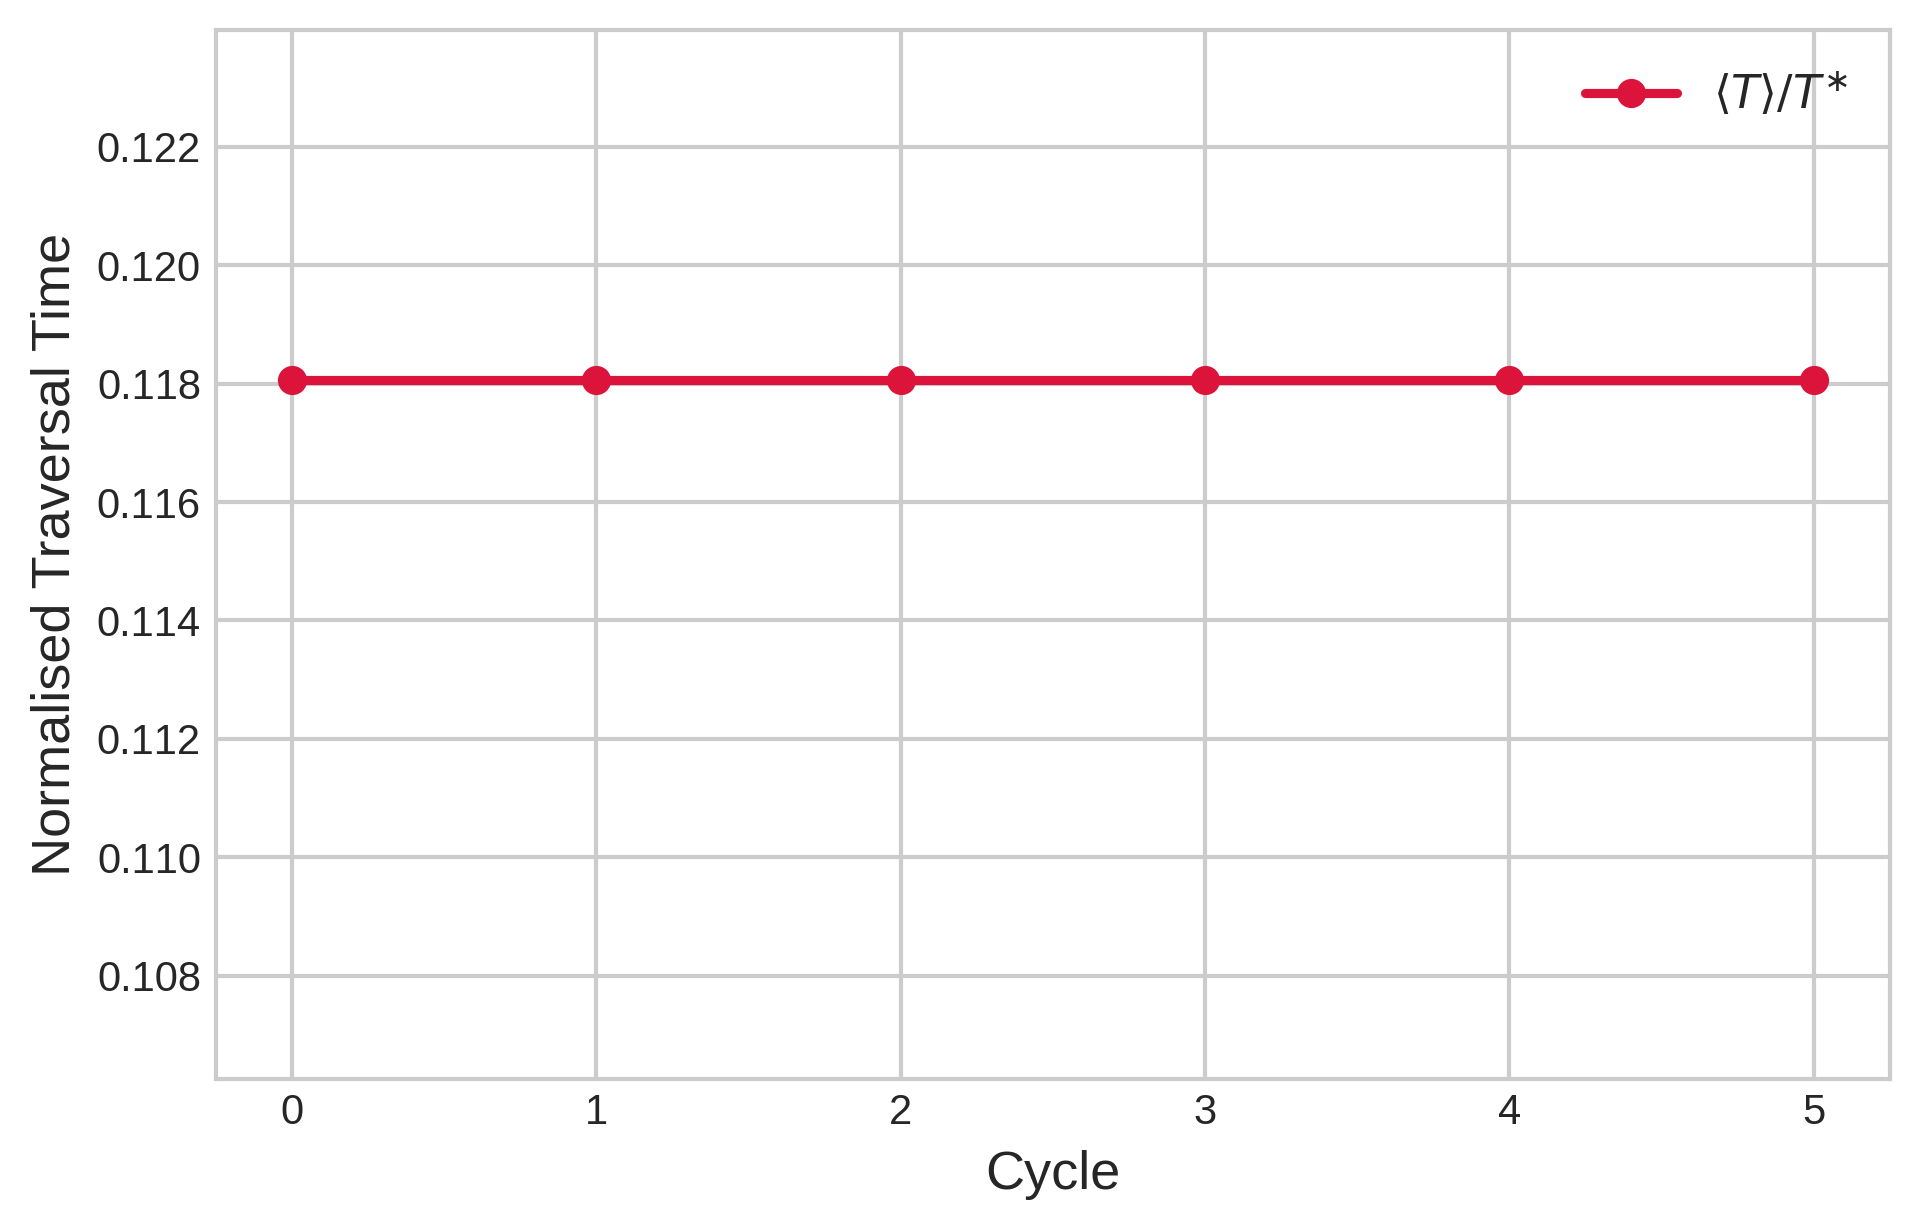

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
import numpy as np

# ---------------- 1.  Snell-optimal time -----------------------------------
base_nu, jump_nu, y_int = 1.0, 10.0, 0.5
xs   = np.linspace(0, 1, 2001)
T_of = lambda xc: base_nu*np.hypot(xc, y_int) + jump_nu*np.hypot(1-xc, 1-y_int)
T_star = T_of(xs).min()

# ---------------- 2.  Normalised traversal times ---------------------------
avg_times   = compute_mean_traversal_times(all_forward, dt)
norm_times  = np.array(avg_times) / T_star
cycles      = np.arange(len(norm_times))

# ---------------- 3.  Plot --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(6.5, 4.2), dpi=300)

ax.plot(cycles, norm_times,
        color="crimson", lw=2.2, marker="o", ms=6,
        label=r"$\langle T\rangle / T^{\ast}$")

# ── grids & labels
ax.set_xlabel("Cycle", fontsize=13)
ax.set_ylabel("Normalised Traversal Time", fontsize=13)
# ax.set_title("Convergence toward Snell-optimal traversal time", fontsize=14)
ax.grid(which="major", color="0.8", lw=1.0)
# ax.grid(which="minor", color="0.9", lw=0.6, ls="--")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim(0.9*norm_times.min(), 1.05*norm_times.max())

# ── add explanatory legend entry (dummy patch)
explain = mpatches.Patch(color='none',
         label=r"$\langle T\rangle$: mean traversal time\n"
               r"$T^{\ast}$: Snell-optimal time")
handles, labels = ax.get_legend_handles_labels()
handles.append(explain); labels.append('')
ax.legend(handles, labels, fontsize=11, frameon=False, loc="upper right")

plt.tight_layout()
plt.savefig("snell_time_decay_matplotlib.pdf")
plt.show()


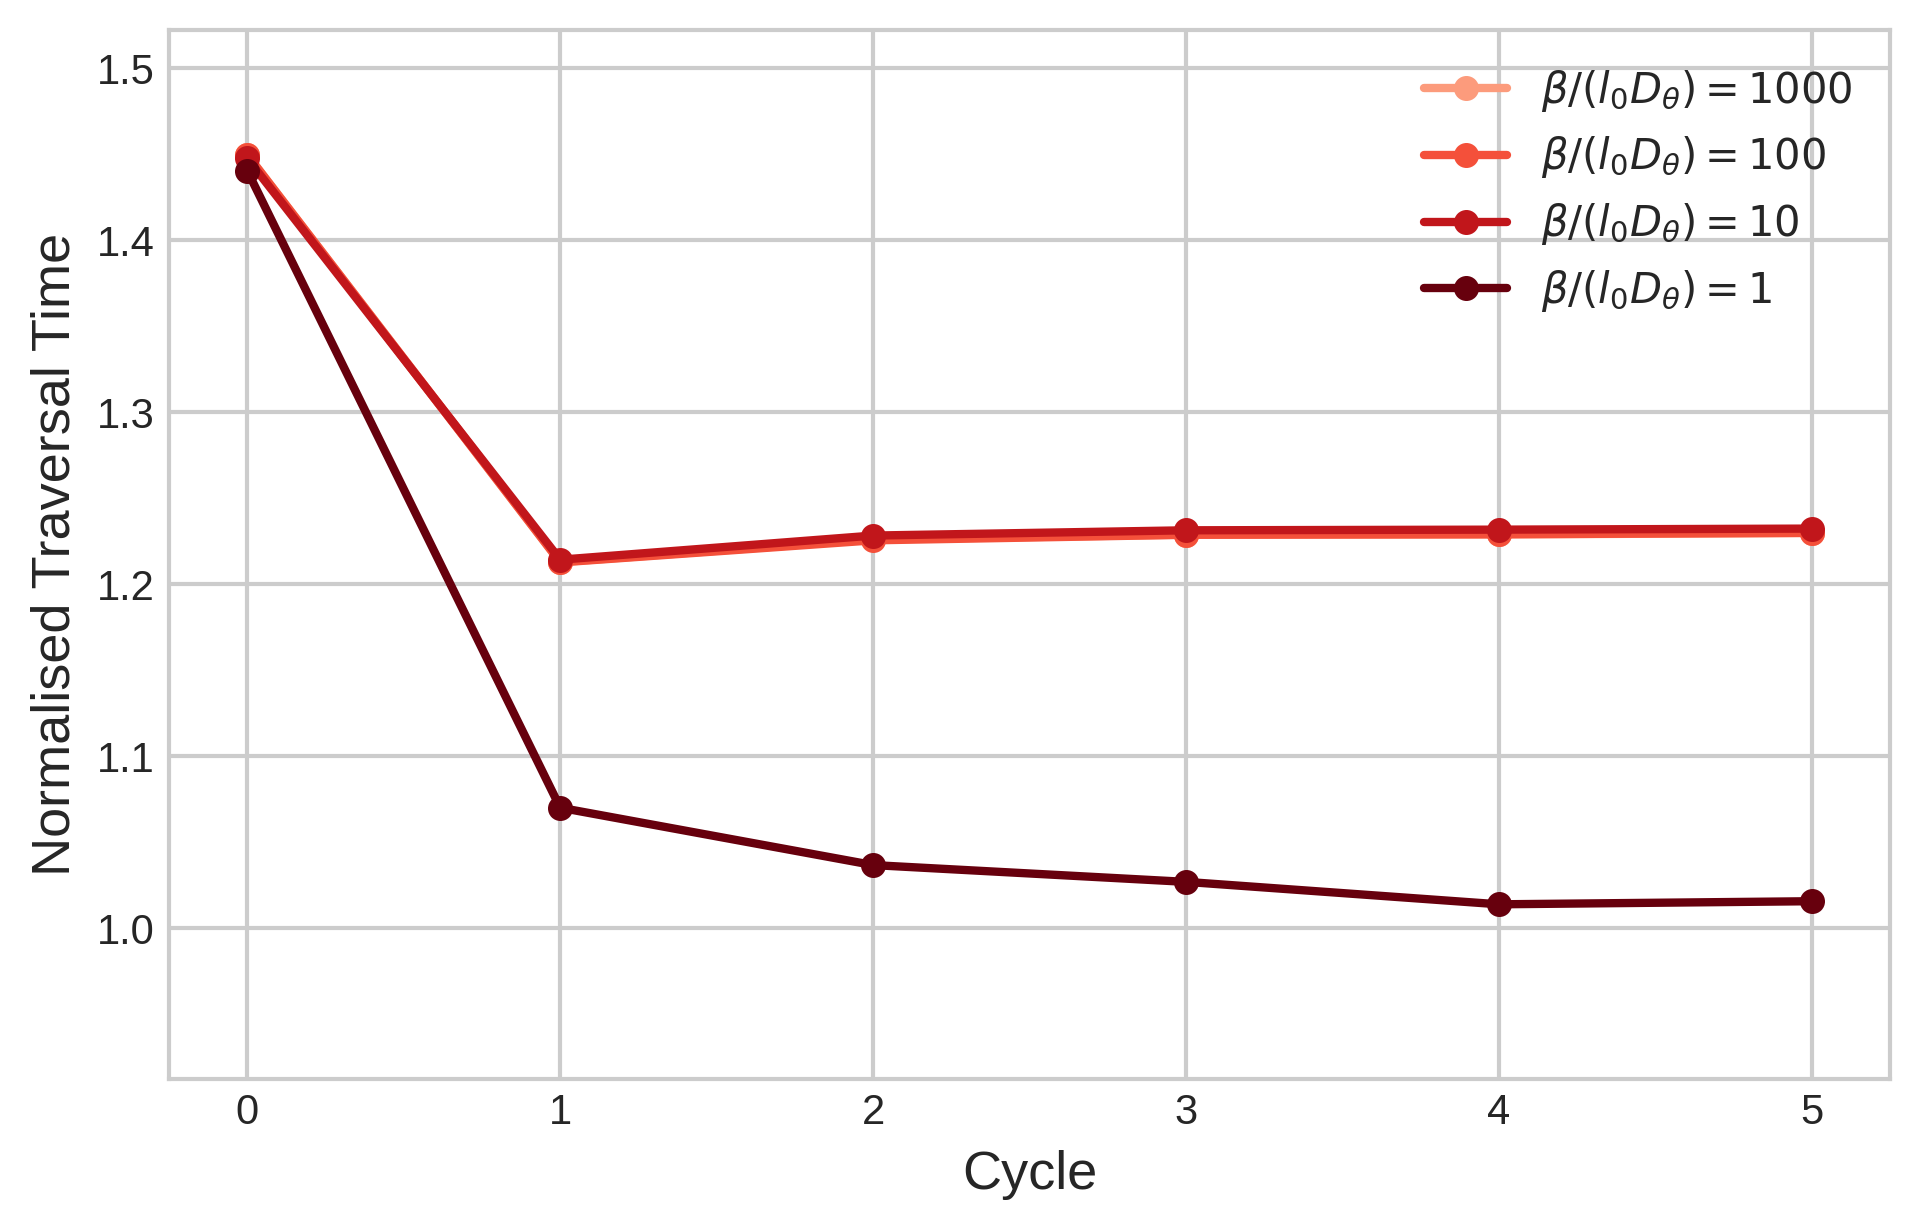

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
import jax.random as jrandom

# ---------- 1.  Snell-optimal time  T* (compute once) ----------------------
base_nu, jump_nu, y_int = 1.0, 10.0, 0.5
xs  = np.linspace(0.0, 1.0, 4001)
T_of = lambda xc: base_nu*np.hypot(xc, y_int) + jump_nu*np.hypot(1-xc, 1-y_int)
T_star = T_of(xs).min()

# ---------- 2.  Dθ list and colours ---------------------------------------
Dtheta_vals = [0.001, 0.01, 0.1, 1.0]               # adjust as needed
# colours      = plt.cm.viridis(np.linspace(0, 1, len(Dtheta_vals)))
colours = plt.cm.Reds(np.linspace(0.35, 1.0, len(Dtheta_vals)))

# all_norm_curves = []
# for Dtheta in Dtheta_vals:
#     sigma_noise = Dtheta                # mapping Dθ → σ
#     forward_params['sigma_noise']  = sigma_noise
#     backward_params['sigma_noise'] = sigma_noise

#     all_fwd, all_bwd, _ = run_apic_loop(
#         num_cycles=num_cycles,
#         key=jrandom.PRNGKey(int(99 + 100*Dtheta)),
#         init_fn=init_fn,
#         point_a=point_a, point_b=point_b,
#         pher_sigma=0.05,
#         forward_params=forward_params,
#         backward_params=backward_params
#     )

#     times      = compute_mean_traversal_times(all_fwd, dt)
#     norm_times = np.array(times) / T_star
#     all_norm_curves.append(norm_times)

# ---------- 3.  Plot all curves -------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(6.5, 4.2), dpi=300)

for norm, Dθ, col in zip(all_norm_curves, Dtheta_vals, colours):
    ax.plot(np.arange(len(norm)), norm,
            color=col, lw=2.0, marker='o', ms=5,
            label=rf"$\beta/ (l_0 D_\theta) = {1/Dθ:g}$")

# grids & labels
ax.set_xlabel("Cycle", fontsize=13)
ax.set_ylabel("Normalised Traversal Time", fontsize=13)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# common y-range from all curves
all_vals = np.concatenate(all_norm_curves)
ax.set_ylim(0.9*all_vals.min(), 1.05*all_vals.max())
ax.grid(which="major", color="0.8", lw=1.0)

# explanatory legend entry
explain = mpatches.Patch(
    color='none',
    label=r"$\langle T\rangle$: mean traversal time" "\n"
          r"$T^{\ast}$: Snell-optimal time")
h, l = ax.get_legend_handles_labels()
h.append(explain); l.append('')
ax.legend(h, l, fontsize=10, frameon=False, loc="upper right")

plt.tight_layout()
plt.savefig("snell_time_decay_multiD.pdf", dpi=300)
plt.show()

In [ ]:
import numpy as np, matplotlib.pyplot as plt, jax.random as jrandom
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# ---------- 1.  Snell-optimal time  T* (unchanged) -------------------------
base_nu, jump_nu, y_int = 1.0, 10.0, 0.5
xs = np.linspace(0, 1, 4001)
T_star = (base_nu*np.hypot(xs, y_int) +
          jump_nu*np.hypot(1-xs, 1-y_int)).min()

# ---------- 2.  helper for one trajectory block ---------------------------
def mean_traversal_time(trajs, dt):
    T, B, _ = trajs.shape
    xy = np.asarray(trajs)[..., :2].reshape(-1, 2)
    x, y = xy[:, 0], xy[:, 1]
    nu_vec = jax.vmap(smooth_piecewise_nu, in_axes=(0, 0))
    nu = np.asarray(nu_vec(x, y)).reshape(T, B)
    return nu.sum(axis=0).mean() * dt          # average over agents

# ---------- 3.  parameter sweep -------------------------------------------
pher_sigmas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]   # edit as needed
n_runs      = 25

means, cimin, cimax = [], [], []

for ps in pher_sigmas:
    ratios = []
    forward_params['sigma_noise']  = sigma_noise  # keep β/ℓD fixed
    backward_params['sigma_noise'] = sigma_noise

    for run in range(n_runs):
        seed = 1234 + int(1e4*ps) + run          # unique seed
        fwd, bwd, _ = run_apic_loop(
            num_cycles=6, key=jrandom.PRNGKey(seed),
            init_fn=init_fn, point_a=point_a, point_b=point_b,
            pher_sigma=ps, forward_params=forward_params,
            backward_params=backward_params
        )
        T_mean = mean_traversal_time(fwd[-1], dt) / T_star
        ratios.append(T_mean)

    ratios = np.array(ratios)
    mu  = ratios.mean()
    se  = ratios.std(ddof=1) / np.sqrt(n_runs)
    ci  = 1.96 * se                        # 95 % CI
    means.append(mu);  cimin.append(mu-ci);  cimax.append(mu+ci)

# ---------- 4.  plot -------------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(6.4, 4.0), dpi=300)

ax.errorbar(pher_sigmas, means,
            yerr=[np.array(means)-np.array(cimin),
                  np.array(cimax)-np.array(means)],
            fmt='o-', color='firebrick', lw=2, ms=7, capsize=4,
            label=r"$\langle T\rangle / T^{\ast}$  (mean ±95% CI)")

ax.set_xlabel(r"Pheromone kernel width  $\sigma_{\rm pher}$", fontsize=12)
ax.set_ylabel(r"Normalised traversal time", fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(which="major", color="0.83")
ax.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.savefig("sigma_sweep_CI.pdf", dpi=300)
plt.show()

100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


ValueError: Incompatible shapes for broadcasting: shapes=[(32, 3), (2,)]

100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


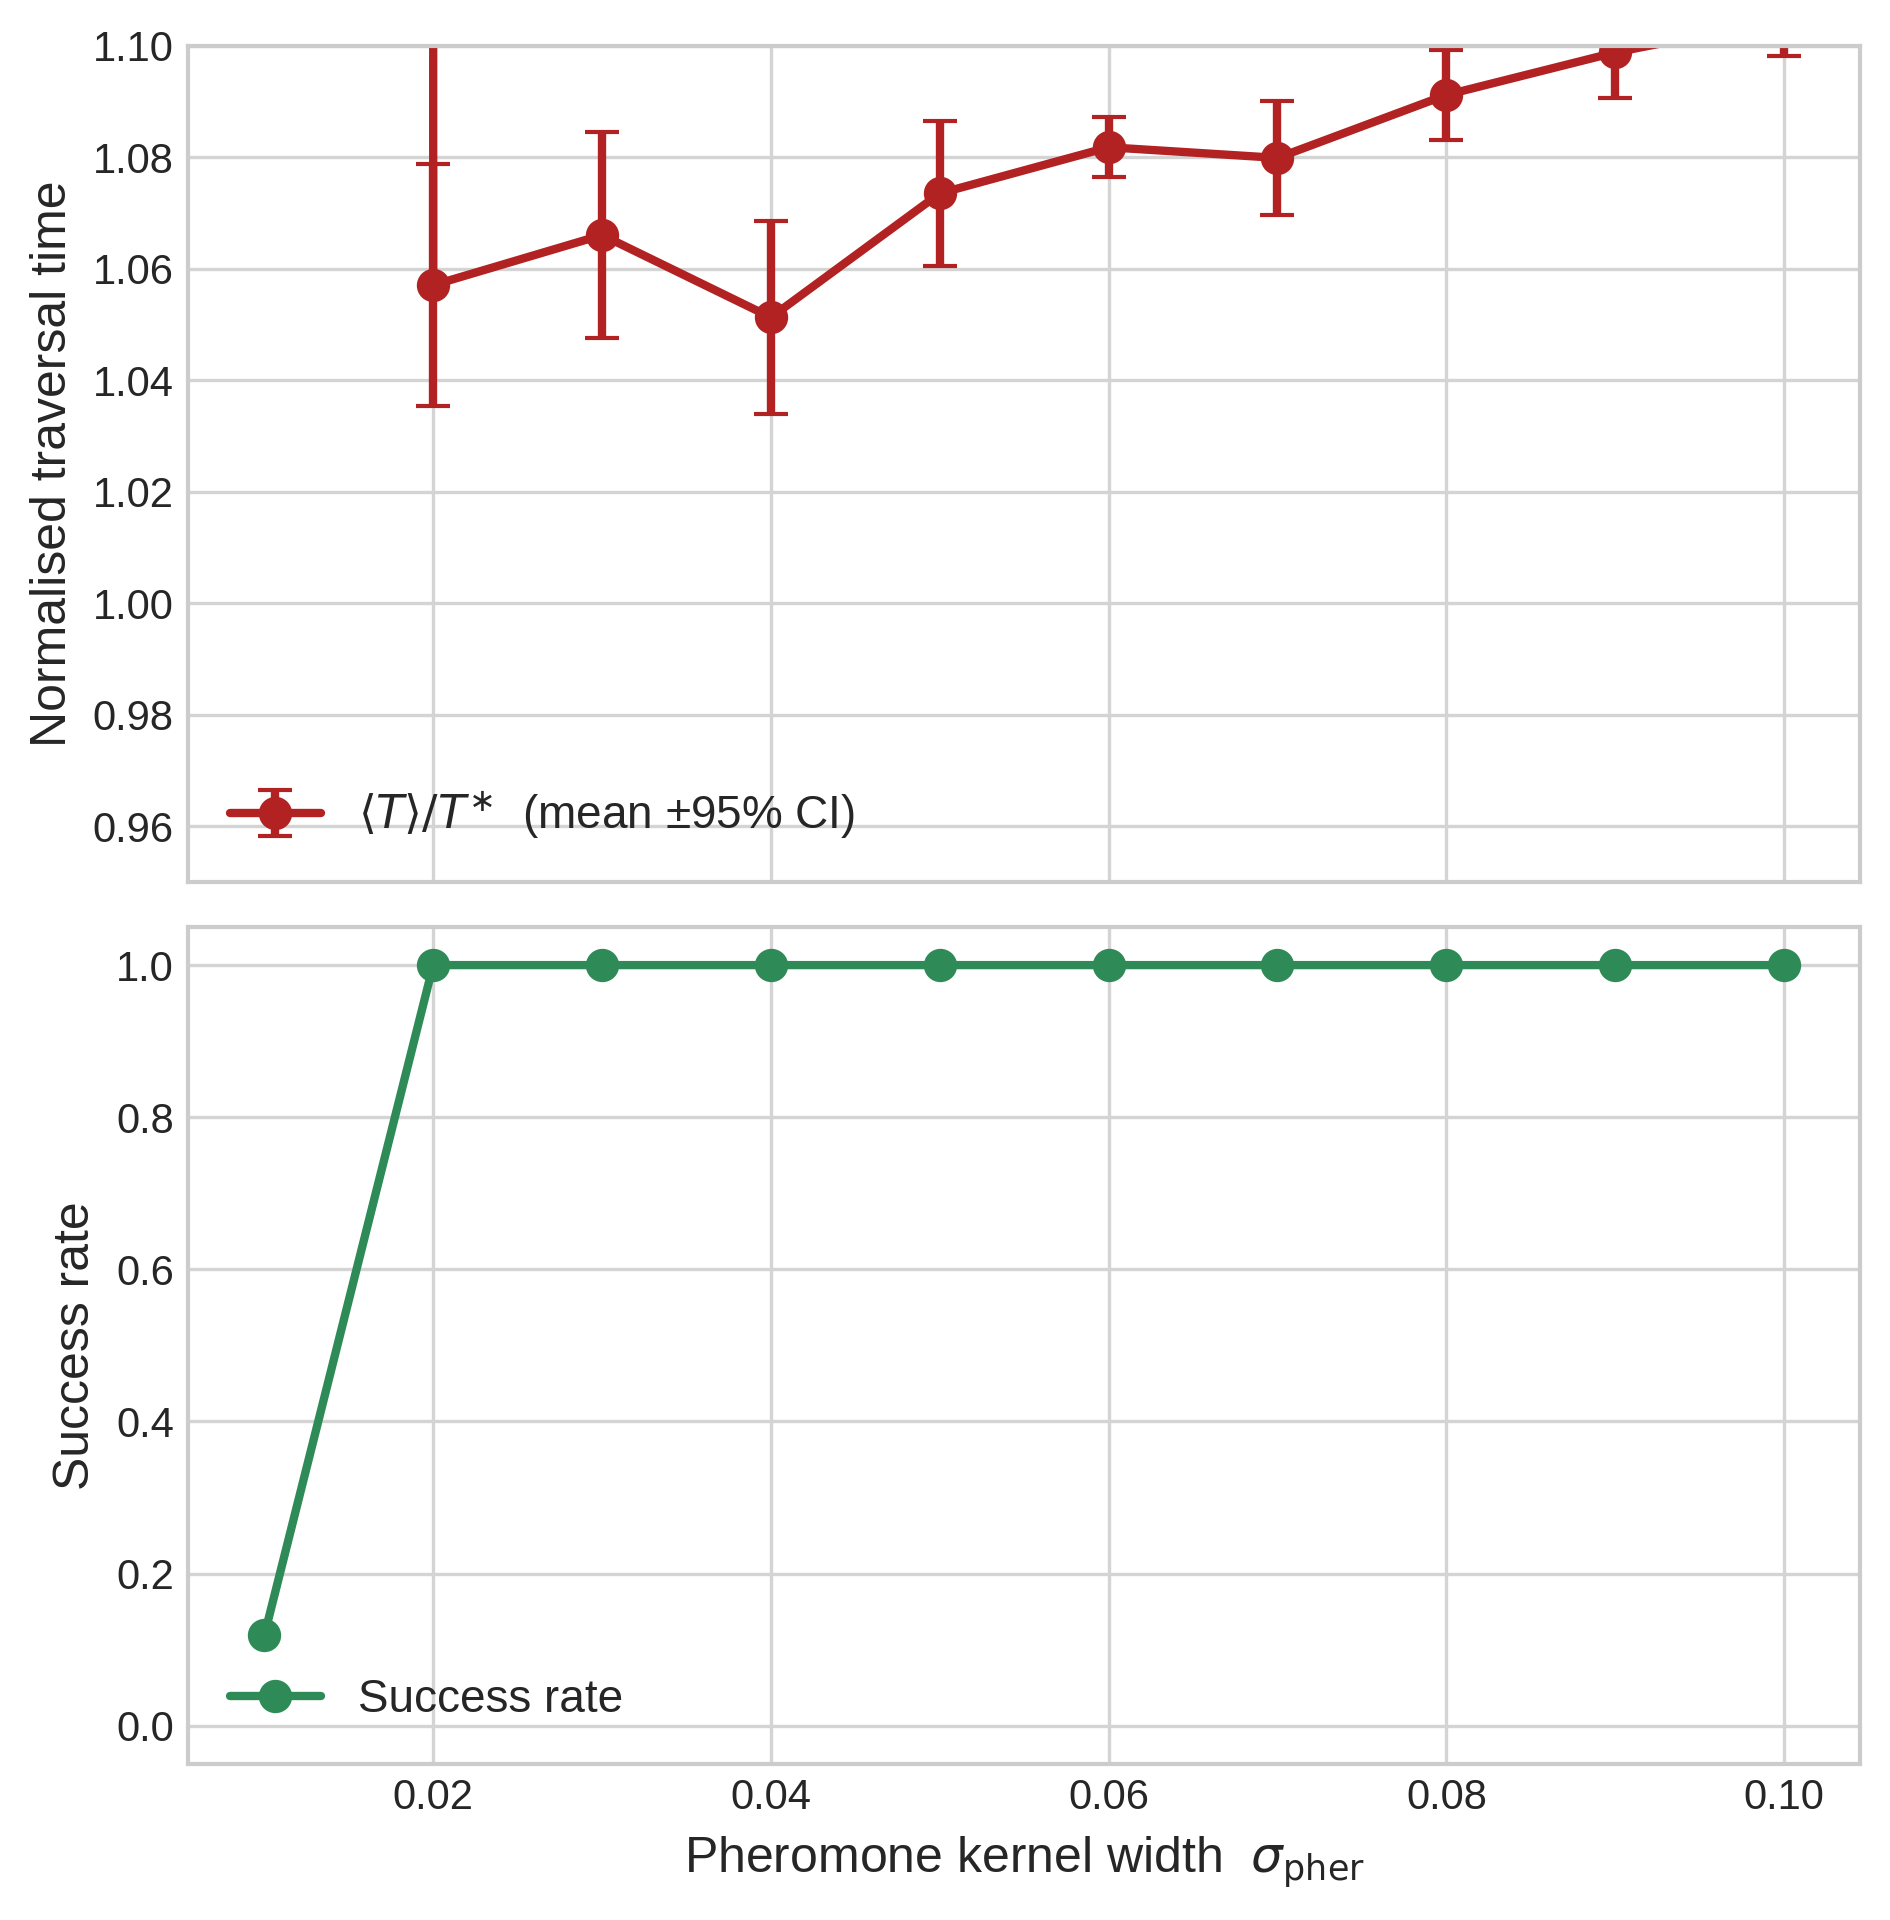

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.random as jrandom
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

# ---------- 1. Theoretical Snell-optimal time T* -------------------------
base_nu, jump_nu, y_int = 1.0, 10.0, 0.5
xs = np.linspace(0, 1, 4001)
T_star = (base_nu*np.hypot(xs, y_int) + jump_nu*np.hypot(1-xs, 1-y_int)).min()

# ---------- 2. Helper: mean time with failure penalty --------------------
def mean_traversal_time_with_success_filter(trajs, dt, point_b, success_thresh=0.1, fail_penalty=9999.0):
    T, B, _ = trajs.shape
    trajs_np = np.asarray(trajs)

    final_xy = trajs_np[-1, :, :2]
    dist_to_goal = np.linalg.norm(final_xy - point_b[None, :], axis=1)
    success_mask = dist_to_goal < success_thresh

    # Optical time: sum of nu along each agent’s path
    xy = trajs_np[..., :2].reshape(-1, 2)
    x, y = xy[:, 0], xy[:, 1]
    nu_vec = jax.vmap(smooth_piecewise_nu, in_axes=(0, 0))
    nu = np.asarray(nu_vec(x, y)).reshape(T, B)
    time_all = nu.sum(axis=0) * dt

    # Penalize failed agents
    time_all[~success_mask] = fail_penalty

    return time_all.mean()

# ---------- 3. Helper: compute success rate ------------------------------
def success_rate(trajs, point_b, thresh=0.1):
    final_xy = np.asarray(trajs)[-1, :, :2]
    dist_to_goal = np.linalg.norm(final_xy - point_b[None, :], axis=1)
    return np.mean(dist_to_goal < thresh)

# ---------- 4. Parameter sweep over pheromone sigma ----------------------
pher_sigmas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
n_runs = 10

means, cimin, cimax = [], [], []
success_rates = []

for ps in pher_sigmas:
    ratios = []
    successes = []

    forward_params['sigma_noise'] = sigma_noise
    backward_params['sigma_noise'] = sigma_noise

    for run in range(n_runs):
        seed = 1234 + int(1e4 * ps) + run
        fwd, bwd, _ = run_apic_loop(
            num_cycles=6,
            key=jrandom.PRNGKey(seed),
            init_fn=init_fn,
            point_a=point_a,
            point_b=point_b,
            pher_sigma=ps,
            forward_params=forward_params,
            backward_params=backward_params,
        )
        t_mean = mean_traversal_time_with_success_filter(fwd[-1], dt, point_b, success_thresh=0.1)
        ratios.append(t_mean / T_star)
        successes.append(success_rate(fwd[-1], point_b, thresh=0.1))

    ratios = np.array(ratios)
    mu = ratios.mean()
    se = ratios.std(ddof=1) / np.sqrt(n_runs)
    ci = 1.96 * se

    means.append(mu)
    cimin.append(mu - ci)
    cimax.append(mu + ci)
    success_rates.append(np.mean(successes))

# ---------- 5. Plot traversal time + success rate ------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 6.5), dpi=300, sharex=True)

# Traversal time with CI
ax1.errorbar(pher_sigmas, means,
             yerr=[np.array(means)-np.array(cimin), np.array(cimax)-np.array(means)],
             fmt='o-', color='firebrick', lw=2, ms=7, capsize=4,
             label=r"$\langle T\rangle / T^{\ast}$  (mean ±95% CI)")
ax1.set_ylabel(r"Normalised traversal time", fontsize=12)
ax1.set_ylim(0.95, 1.1)
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.grid(which="major", color="0.83")
ax1.legend(frameon=False, fontsize=11)

# Success rate
ax2.plot(pher_sigmas, success_rates, 'o-', color='seagreen', lw=2, ms=7, label="Success rate")
ax2.set_xlabel(r"Pheromone kernel width  $\sigma_{\rm pher}$", fontsize=12)
ax2.set_ylabel("Success rate", fontsize=12)
ax2.set_ylim(-0.05, 1.05)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(which="major", color="0.83")
ax2.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.savefig("sigma_sweep_failure_handling.pdf", dpi=300)
plt.show()

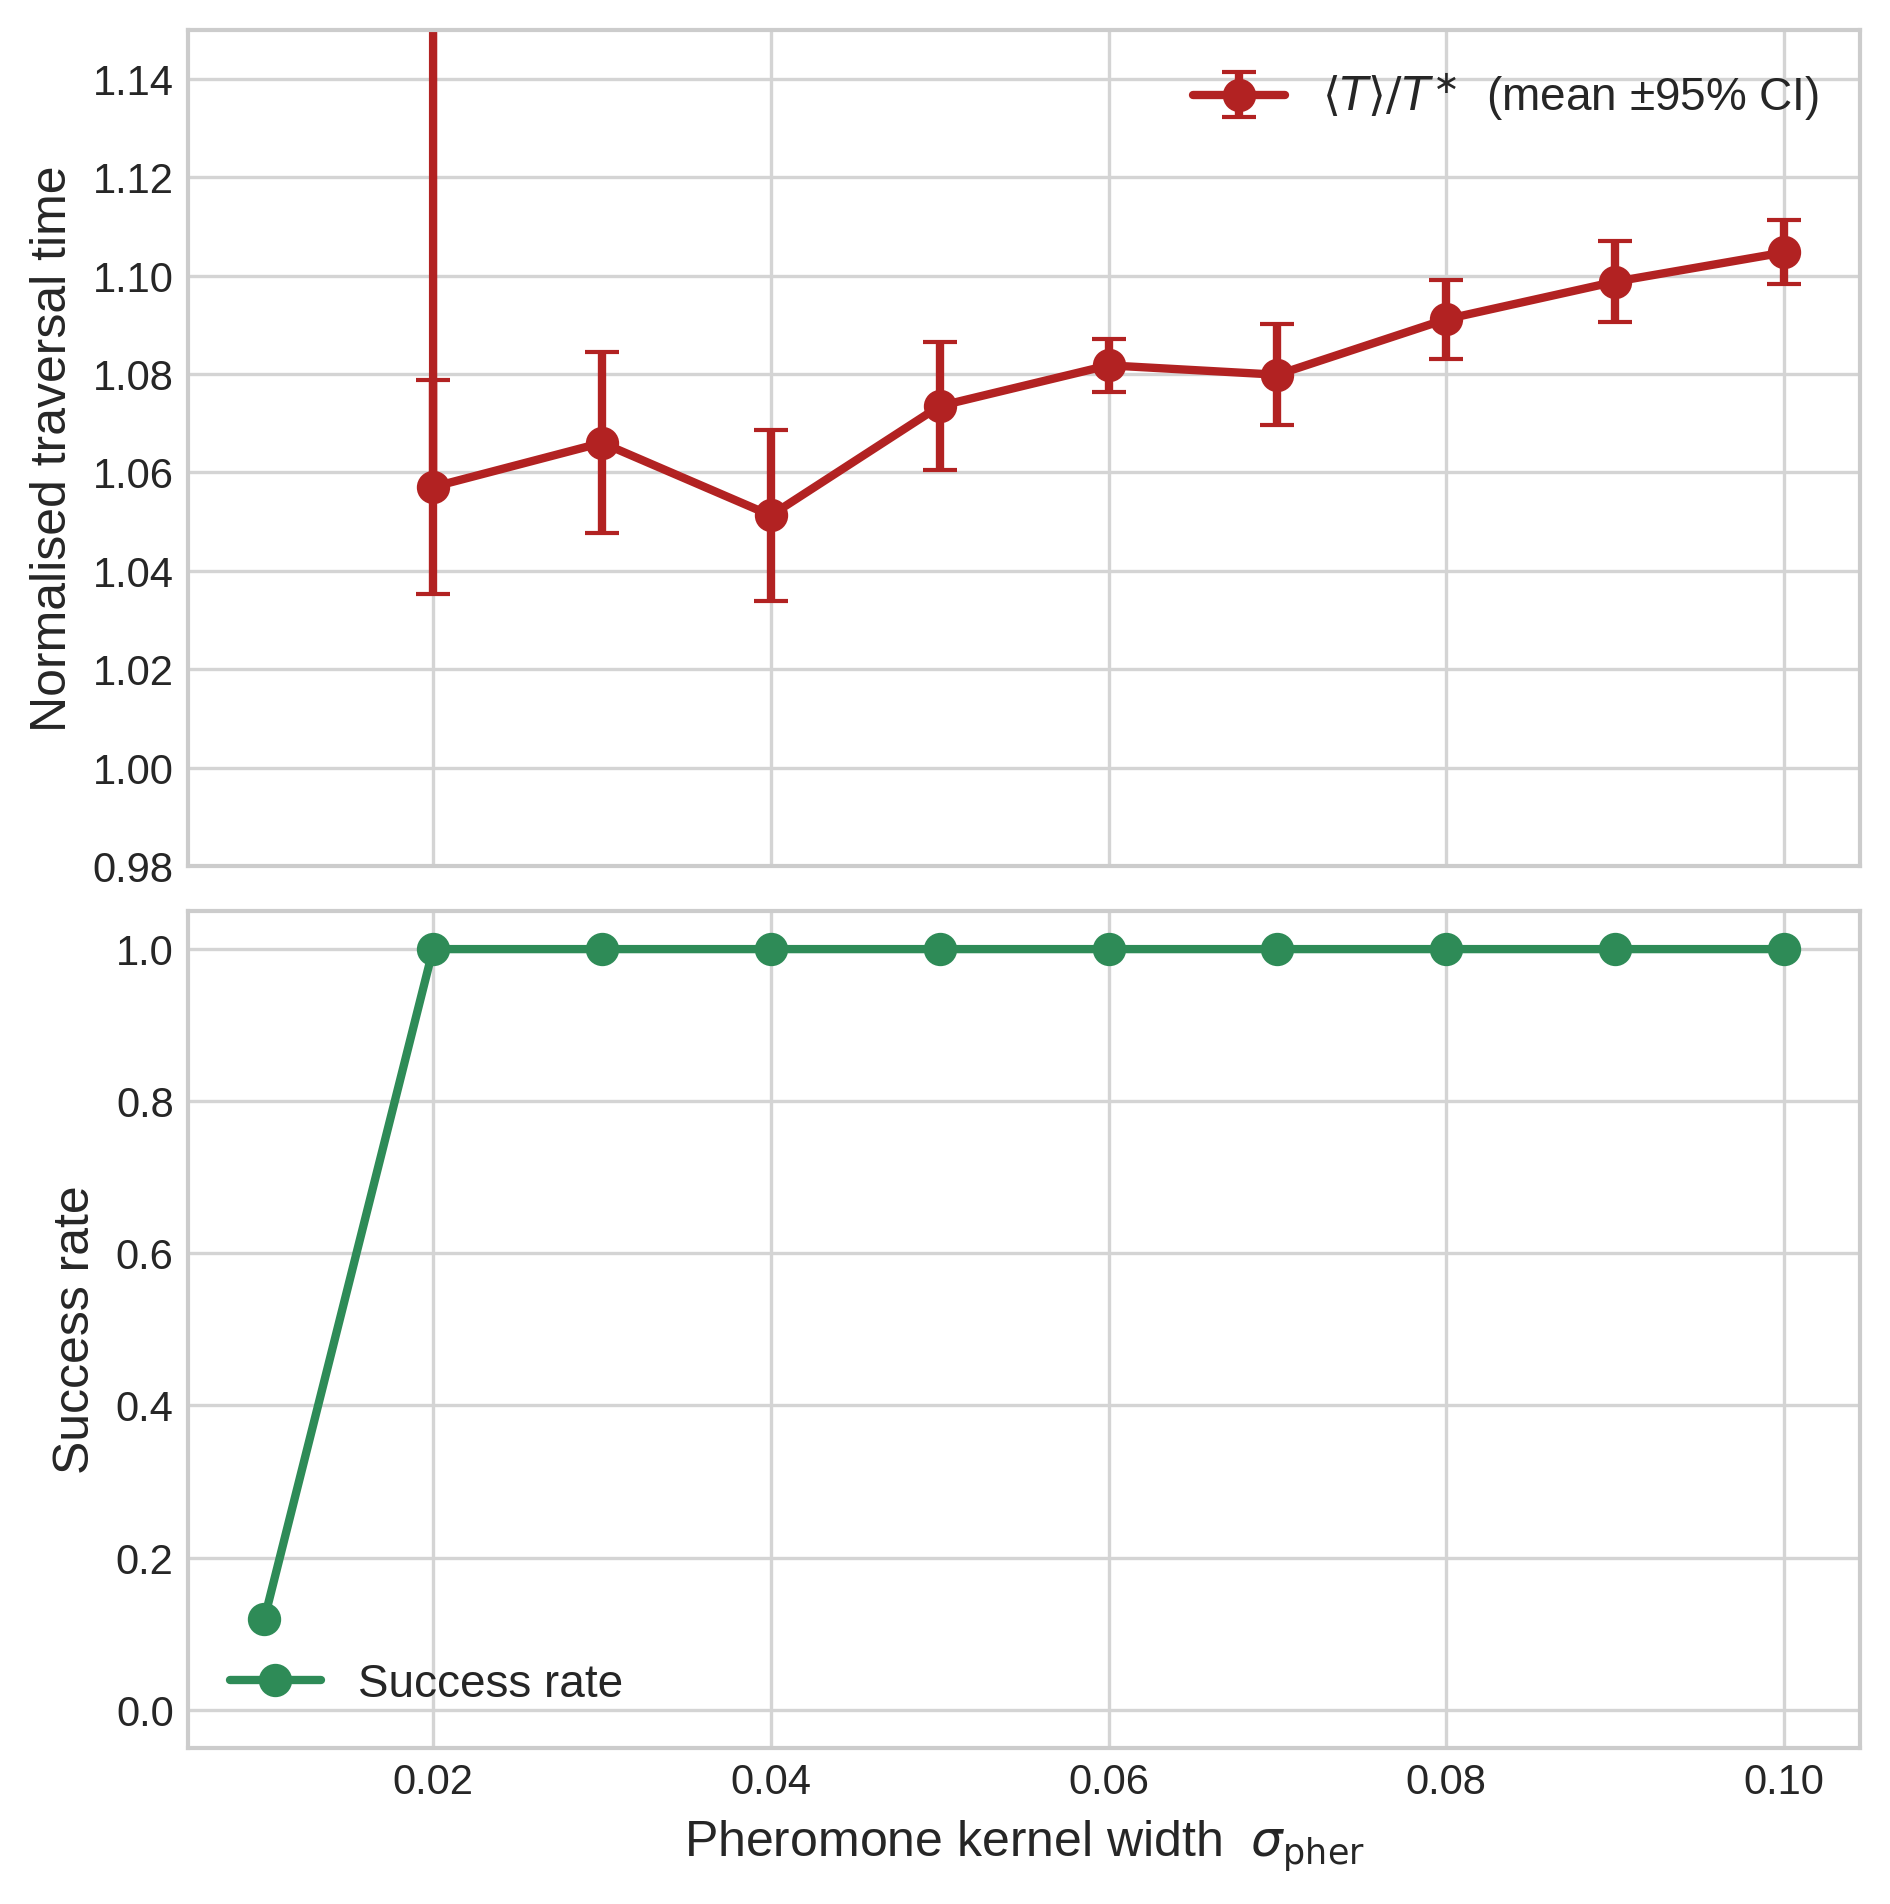

In [ ]:
# ---------- 5. Plot traversal time + success rate ------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 6.5), dpi=300, sharex=True)

# Traversal time with CI
ax1.errorbar(pher_sigmas, means,
             yerr=[np.array(means)-np.array(cimin), np.array(cimax)-np.array(means)],
             fmt='o-', color='firebrick', lw=2, ms=7, capsize=4,
             label=r"$\langle T\rangle / T^{\ast}$  (mean ±95% CI)")
ax1.set_ylabel(r"Normalised traversal time", fontsize=12)
ax1.set_ylim(0.98, 1.15)
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.grid(which="major", color="0.83")
ax1.legend(frameon=False, fontsize=11)

# Success rate
ax2.plot(pher_sigmas, success_rates, 'o-', color='seagreen', lw=2, ms=7, label="Success rate")
ax2.set_xlabel(r"Pheromone kernel width  $\sigma_{\rm pher}$", fontsize=12)
ax2.set_ylabel("Success rate", fontsize=12)
ax2.set_ylim(-0.05, 1.05)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(which="major", color="0.83")
ax2.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.savefig("sigma_sweep_failure_handling.pdf", dpi=300)
plt.show()

Saved animation →  apic_cycles.mp4


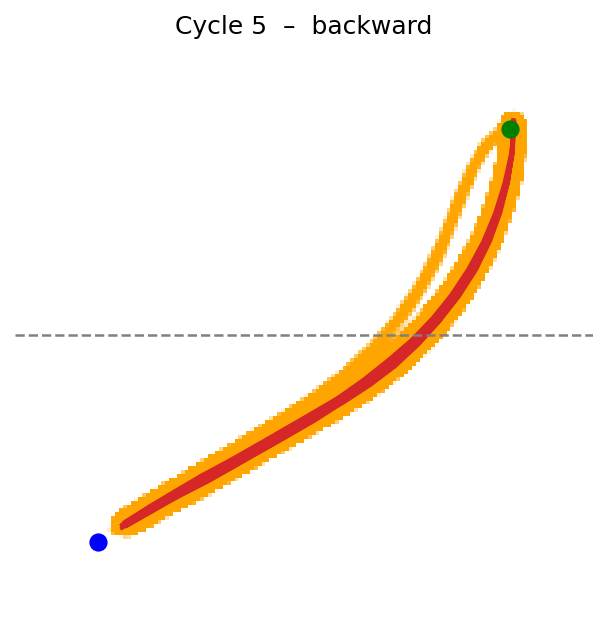

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors

# ------------ configurable parameters ------------------------------------
grid_size          = 150          # heat-map resolution
sigma_field        = 0.01         # Gaussian width for heat-map
decay_rate         = 0.1          # pheromone decay per cycle
frames_per_phase   = 20           # 20 → forward, 20 → backward
fps                = 12           # video FPS
outfile            = "apic_cycles.mp4"
# -------------------------------------------------------------------------

# === 1.  pre-compute heat-maps (one per cycle)  ===========================
def pheromone_field_for_cycle(cycle_idx):
    """Field built from backward[0 … cycle_idx-1] with exponential decay."""
    xmin, xmax, ymin, ymax = -0.2, 1.2, -0.2, 1.2
    xg = np.linspace(xmin, xmax, grid_size)
    yg = np.linspace(ymin, ymax, grid_size)
    X , Y = np.meshgrid(xg, yg, indexing='ij')
    field = np.zeros_like(X)

    for i in range(cycle_idx):
        decay = decay_rate ** (cycle_idx-1-i)
        pts   = np.asarray(all_backward[i][..., :2]).reshape(-1, 2)
        for px, py in pts:
            dx = X - px
            dy = Y - py
            field += decay*np.exp(-(dx**2+dy**2)/(2*sigma_field**2))

    return np.log(0.01+field)

heatmaps = [pheromone_field_for_cycle(k)
            for k in range(len(all_forward))]

# colour-map (white→orange) re-usable
cmap  = mcolors.LinearSegmentedColormap.from_list(
            "white_orange", ["white", "orange"])
norm  = mcolors.Normalize(vmin=0.05, vmax=1.0)

# === 2.  subsample trajectories to 20 steps each ==========================
def subsample(traj, N=frames_per_phase):
    T = traj.shape[0]
    idx = np.linspace(0, T-1, N, dtype=int)
    return traj[idx]                                  # (N, B, 2)

fwd_sub  = [subsample(np.asarray(t)[..., :2]) for t in all_forward]
bwd_sub  = [subsample(np.asarray(t)[..., :2]) for t in all_backward]

# === 3.  set up figure & artists =========================================
xmin, xmax, ymin, ymax = -0.2, 1.2, -0.2, 1.2
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

# initial heatmap
im = ax.imshow(heatmaps[0].T, origin='lower',
               extent=[xmin, xmax, ymin, ymax],
               cmap=cmap, norm=norm, aspect='auto')

lines = [ax.plot([], [], lw=1.5, color='tab:red')[0]
         for _ in range(all_forward[0].shape[1])]

ax.scatter(*point_a,   color='blue',  s=60, zorder=5)
ax.scatter(*point_b,   color='green', s=60, zorder=5)
ax.axhline(0.5, color='gray', ls='--', lw=1.2)
ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)
ax.set_aspect('equal'); ax.axis('off')
title = ax.set_title("Cycle 0  –  forward", fontsize=12)

# === 4.  animation update =================================================
total_frames = len(all_forward)*frames_per_phase*2

def update(frame):
    cycle   = frame // (2*frames_per_phase)
    within  = frame % (2*frames_per_phase)
    phase   = "forward" if within < frames_per_phase else "backward"
    step    = within if phase=="forward" else within-frames_per_phase

    # update heat-map only when cycle changes
    if frame % (2*frames_per_phase) == 0:
        im.set_data(heatmaps[cycle].T)

    # choose trajectories
    traj_block = fwd_sub[cycle] if phase=="forward" else bwd_sub[cycle]

    for b, line in enumerate(lines):
        line.set_data(traj_block[:step+1, b, 0], traj_block[:step+1, b, 1])

    title.set_text(f"Cycle {cycle}  –  {phase}")
    return [im, *lines, title]

# === 5.  create and save animation =======================================
ani = animation.FuncAnimation(fig, update, frames=total_frames,
                              interval=1000/fps, blit=True)
ani.save(outfile, writer='ffmpeg', fps=fps)
print(f"Saved animation →  {outfile}")

# diff ref steepness

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

steep_vals = np.linspace(1, 100, 10)
base = 1.0
jump = 10.0
num_cycles = 3
batch_size = 32
representative_trajs = []
representative_pheromones = []
mean_lengths = []

# Precompute Snell-optimal path length
def snell_path_length(point_a, point_b, y_interface, nu1, nu2):
    """
    Compute minimum-time Snell path between two points with indices nu1, nu2 split at y_interface.
    """
    from scipy.optimize import minimize_scalar

    xa, ya = point_a
    xb, yb = point_b

    def time_cost(xi):
        # refraction point at (xi, y_interface)
        L1 = np.sqrt((xi - xa)**2 + (y_interface - ya)**2)
        L2 = np.sqrt((xb - xi)**2 + (yb - y_interface)**2)
        return L1 * nu1 + L2 * nu2  # Time ∝ length × index (v = 1/nu)

    res = minimize_scalar(time_cost, bounds=(0, 1), method='bounded')
    return time_cost(res.x)

snell_optimal_length = snell_path_length([0.0, 0.0], [1.0, 1.0], 0.5, base, jump)

# Sweep over steepness values
for steep in steep_vals:
    def nu_fn(x, y):
        s = 1.0 / (1.0 + jnp.exp(-steep * (y - 0.5)))
        return base * (1 - s) + jump * s

    # Patch into global scope for use in simulate
    smooth_piecewise_nu = nu_fn

    # Create init function
    init_fn = make_init_fn(point_a, point_b, batch_size)

    all_forward, all_backward, pher_pts, _ = run_apic_loop(
        num_cycles=num_cycles,
        key=random.PRNGKey(0),  # different seed per steep
        init_fn=init_fn,
        point_a=point_a,
        point_b=point_b,
        pher_sigma=0.05,
        forward_params=forward_params,
        backward_params=backward_params
    )

    traj = all_forward[-1][:, 0]  # (T, 3)
    representative_trajs.append(np.array(traj))  # convert from JAX to NumPy
    representative_pheromones.append(np.array(pher_pts))

    x, y = traj[:, 0], traj[:, 1]
    length = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
    mean_lengths.append(length)

100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


In [ ]:
traj = all_forward[-1][:, 0]  # (T, 3)
pheromone_from_this_traj = traj[:, :2]
representative_pheromones.append(np.array(pheromone_from_this_traj))

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 5, figsize=(15, 30))
axes = axes.flatten()

for i, (traj, pher, steep) in enumerate(zip(representative_trajs, representative_pheromones, steep_vals)):
    ax = axes[i]
    x, y = traj[:, 0], traj[:, 1]

    # === Pheromone heatmap ===
    hb = ax.hist2d(
        pher[:, 0], pher[:, 1],
        bins=100,
        range=[[0, 1], [0, 1]],
        cmap='YlOrRd',
        cmin=1e-5,
        density=False
    )

    # === Trajectory ===
    ax.plot(x, y, color='black', lw=1.5)

    # === Markers and Layout ===
    ax.scatter([point_a[0]], [point_a[1]], color='red', label='Start', s=20, zorder=3)
    ax.scatter([point_b[0]], [point_b[1]], color='blue', label='Goal', s=20, zorder=3)
    ax.axhline(0.5, color='gray', linestyle='--', lw=1)
    nu_mid = 0.5 * (base + jump)  # ν at y = 0.5
    beta = 1.0  # your code uses this as control gain
    log_nu_grad_y = steep * (jump - base) / (4 * nu_mid)
    control_strength = log_nu_grad_y * jnp.linalg.norm(point_b - point_a)
    ax.set_title(f"$\ell_0 \\nabla \\log\\nu$ = {control_strength:.2f}")
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xticks([]); ax.set_yticks([])

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Final Trajectories and Pheromone Heatmaps vs. Refractive Steepness", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Add colorbar manually
cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])  # [left, bottom, width, height]
fig.colorbar(hb[3], cax=cbar_ax, label="Pheromone Density")

plt.savefig("trajectories_vs_steep.pdf", dpi=300)
plt.close()

In [ ]:
grid_size = 100
x = jnp.linspace(-0.5, 1.0, grid_size)
y = jnp.linspace(-0.5, 1.5, grid_size)
X, Y = jnp.meshgrid(x, y)

In [ ]:
def create_pheromone_trail_from_trajectory(trajectory, X, Y, sigma=0.05):
    pheromone_field = jnp.zeros_like(X)
    for p in trajectory:
        pheromone_field += gaussian_kernel(X - p[0], Y - p[1], sigma)
    return pheromone_field

KeyboardInterrupt: 

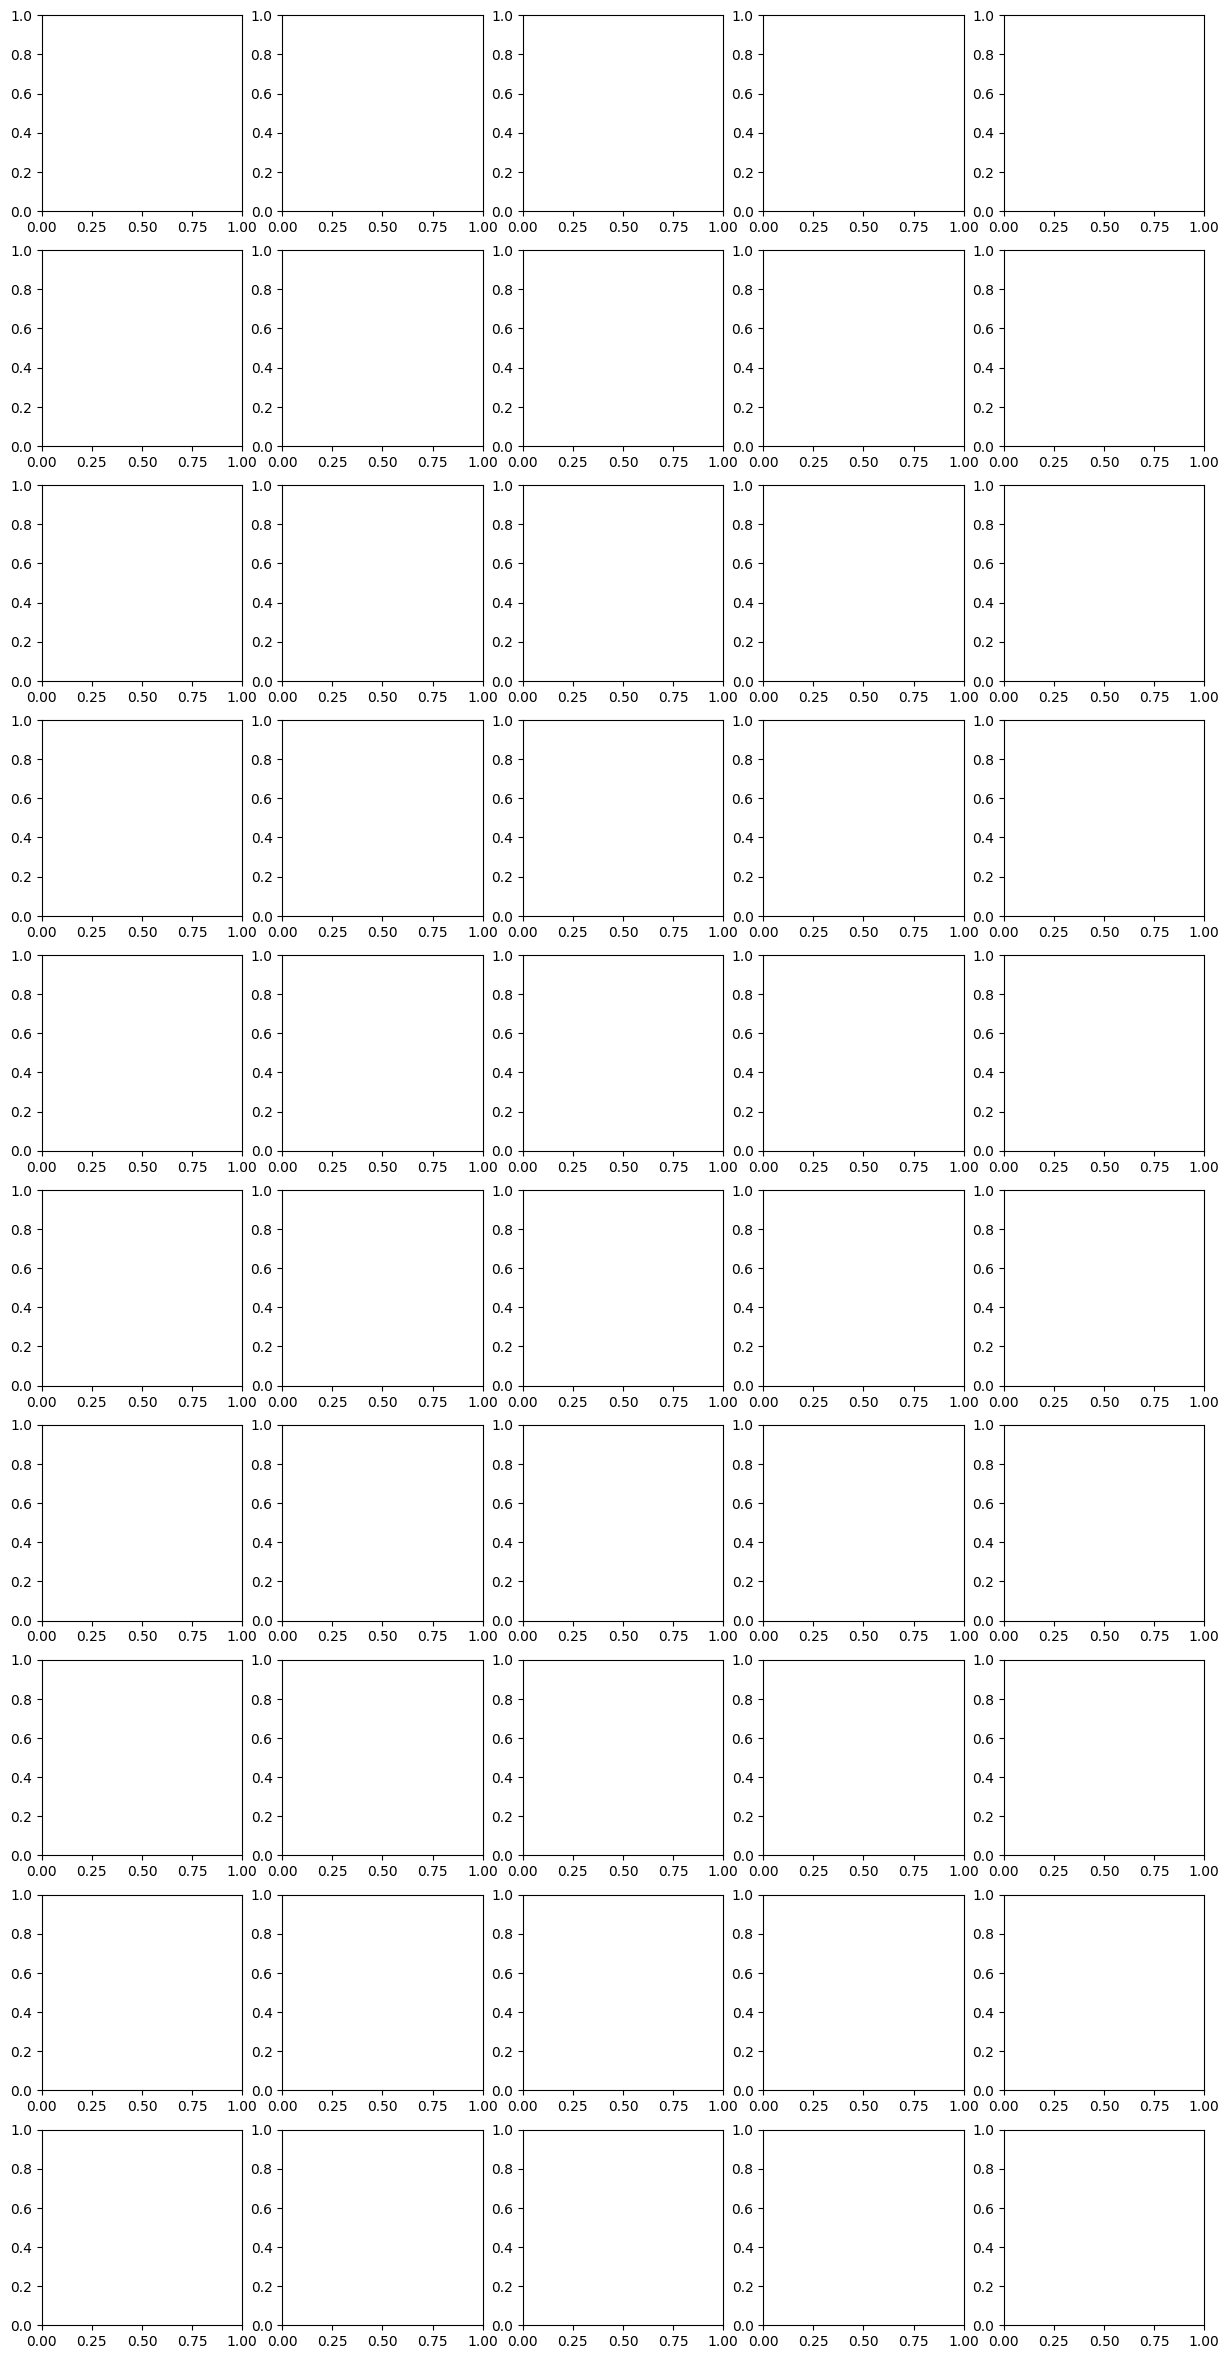

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(10, 5, figsize=(15, 30))
axes = axes.flatten()

# Custom colormap and normalization
white_orange = ListedColormap(["white"] + plt.get_cmap('YlOrRd')(np.linspace(0.2, 1.0, 256)).tolist())
norm = LogNorm(vmin=1e-3, vmax=1.0)

for i, (traj, pher, steep) in enumerate(zip(representative_trajs, representative_pheromones, steep_vals)):
    ax = axes[i]
    x, y = traj[:, 0], traj[:, 1]

    # === Pheromone heatmap (kernel density style) ===
    pheromone_field = create_pheromone_trail_from_trajectory(pher, X, Y)
    im = ax.contourf(X, Y, pheromone_field, levels=100, cmap=white_orange, norm=norm)

    # === Trajectory ===
    ax.plot(x, y, color='black', lw=1.5)

    # === Markers and Layout ===
    ax.scatter([point_a[0]], [point_a[1]], color='red', label='Start', s=20, zorder=3)
    ax.scatter([point_b[0]], [point_b[1]], color='blue', label='Goal', s=20, zorder=3)
    ax.axhline(0.5, color='gray', linestyle='--', lw=1)
    nu_mid = 0.5 * (base + jump)
    beta = 1.0
    log_nu_grad_y = steep * (jump - base) / (4 * nu_mid)
    control_strength = log_nu_grad_y * jnp.linalg.norm(point_b - point_a)
    ax.set_title(f"$\ell_0 \\nabla \\log\\nu$ = {control_strength:.2f}")
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xticks([]); ax.set_yticks([])

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Final Trajectories and Pheromone Heatmaps vs. Refractive Steepness", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Add consistent colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
fig.colorbar(ScalarMappable(norm=norm, cmap=white_orange), cax=cbar_ax, label="Pheromone Density")

plt.savefig("trajectories_vs_steep.pdf", dpi=300)
plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
from matplotlib.cm import ScalarMappable

def create_pheromone_trail_from_trajectory(traj, X, Y, sigma=0.05):
    """
    Vectorized pheromone field computation from trajectory.
    traj: (N, 2)
    X, Y: (H, W) meshgrid arrays
    """
    dx = X[None, :, :] - traj[:, 0][:, None, None]
    dy = Y[None, :, :] - traj[:, 1][:, None, None]
    field = np.exp(-(dx**2 + dy**2) / (2 * sigma**2)).sum(axis=0)
    return field

def plot_trajectories_with_pheromones(
    representative_trajs, representative_pheromones, steep_vals,
    point_a, point_b, base=1.0, jump=10.0, sigma=0.05, grid_size=100
):
    x = np.linspace(-0.5, 1.0, grid_size)
    y = np.linspace(-0.5, 1.5, grid_size)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    # Custom colormap and normalization
    white_orange = ListedColormap(["white"] + plt.get_cmap('YlOrRd')(np.linspace(0.2, 1.0, 256)).tolist())
    norm = LogNorm(vmin=1e-3, vmax=1.0)

    for i, (traj, pher, steep) in enumerate(zip(representative_trajs, representative_pheromones, steep_vals)):
        ax = axes[i]
        x_traj, y_traj = traj[:, 0], traj[:, 1]

        # Pheromone heatmap
        pheromone_field = create_pheromone_trail_from_trajectory(pher, X, Y, sigma=sigma)
        im = ax.contourf(X, Y, pheromone_field, levels=50, cmap=white_orange, norm=norm)

        # Trajectory line
        ax.plot(x_traj, y_traj, color='black', lw=1.5)

        # Start and Goal markers
        ax.scatter([point_a[0]], [point_a[1]], color='red', label='Start', s=20, zorder=3)
        ax.scatter([point_b[0]], [point_b[1]], color='blue', label='Goal', s=20, zorder=3)
        ax.axhline(0.5, color='gray', linestyle='--', lw=1)

        # Title based on control strength
        nu_mid = 0.5 * (base + jump)
        log_nu_grad_y = steep * (jump - base) / (4 * nu_mid)
        control_strength = log_nu_grad_y * np.linalg.norm(point_b - point_a)
        ax.set_title(f"$\ell_0 \\nabla \\log\\nu$ = {control_strength:.2f}")

        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_xticks([]); ax.set_yticks([])

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Final Trajectories and Pheromone Heatmaps vs. Refractive Steepness", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # Colorbar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
    fig.colorbar(ScalarMappable(norm=norm, cmap=white_orange), cax=cbar_ax, label="Pheromone Density")

    plt.savefig("trajectories_vs_steep.pdf", dpi=300)
    plt.close()

In [ ]:
plot_trajectories_with_pheromones(
    representative_trajs, representative_pheromones, steep_vals,
    point_a=point_a, point_b=point_b, base=1.0, jump=10.0, sigma=0.05
)

In [ ]:
def compute_interface_crossing_x(traj, y_interface=0.5):
    """
    Returns x at which the trajectory crosses y = y_interface.
    Uses linear interpolation between the first pair of points crossing y = 0.5
    """
    y = traj[:, 1]
    x = traj[:, 0]

    for i in range(len(y) - 1):
        if (y[i] < y_interface) and (y[i+1] >= y_interface):
            t = (y_interface - y[i]) / (y[i+1] - y[i])
            x_cross = x[i] + t * (x[i+1] - x[i])
            return x_cross
    return np.nan  # No crossing found

In [ ]:
# === Compute interface crossing x-positions
x_crossings = [compute_interface_crossing_x(traj) for traj in representative_trajs]

# === Plot vs. control strength
plt.figure(figsize=(8, 5))
plt.plot(control_strengths, x_crossings, marker='o', color='black', label="x at y=0.5")
plt.xlabel(r"$\nabla \log \nu \cdot D_\theta / \beta$")
plt.ylabel("x-coordinate of Interface Crossing (y = 0.5)")
plt.title("Crossing Position vs. Control Strength")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("x_crossing_vs_control_strength.pdf", dpi=300)
plt.close()

In [ ]:
from scipy.optimize import minimize_scalar
import numpy as np

def snell_optimal_x_crossing(point_a, point_b, nu1, nu2, y_interface=0.5):
    xa, ya = point_a
    xb, yb = point_b

    def optical_path(xc):
        L1 = np.sqrt((xc - xa)**2 + (y_interface - ya)**2)
        L2 = np.sqrt((xb - xc)**2 + (yb - y_interface)**2)
        return nu1 * L1 + nu2 * L2

    result = minimize_scalar(optical_path, bounds=(0.0, 1.0), method='bounded')
    return result.x  # optimal x-crossing


point_a = (0.0, 0.0)
point_b = (1.0, 1.0)
nu1 = 1.0
nu2 = 10.0
x_opt = snell_optimal_x_crossing(point_a, point_b, nu1, nu2)
print(f"Optimal x-crossing under Snell’s law: {x_opt:.4f}")